In [73]:
# critical
import argparse
import os
import random
import time
import math

# machine learning
from sklearn.decomposition import PCA

# deep learning
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torchvision.utils as vutils

# data
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# signal processing
from scipy import signal
from scipy.stats import entropy

Random Seed:  99


In [ ]:
# set random seed for reproducibility
manualSeed = 99
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)

np.random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

In [75]:
device = torch.device("mps")
# device = torch.device("cpu")

# number of channels the signal has
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# number of classes in the conditional dcgan
num_classes = 3

# number of signals per iteration
batch_size = 32

# Number of training epochs
# num_epochs = int(32 * (6000/1684))
num_epochs = 32

# Learning rate for optimizers
lr_g = 0.00002
lr_d = 0.00002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# type of gan
gans_type = "dcgans"

### Dataloader

In [76]:
class GWDataset(Dataset):
    def __init__(self, signals_csv, parameters_csv):
        y = pd.read_csv(parameters_csv)
        self.data = pd.read_csv(signals_csv).astype('float32')
        # remove erroneous parameters
        keep_signals_idx = np.array(y[y['beta1_IC_b'] > 0].index)
        y = y.iloc[keep_signals_idx,:]
        # self.parameters['beta1_IC_b_bins'] = pd.qcut(self.parameters['beta1_IC_b'], q=10, labels=False)
        # self.parameters = self.parameters[['beta1_IC_b_bins']].astype('float32')

        ranges = [0, 0.06, 0.17, 1]
        labels = [0, 1, 2]
        num_classes = len(labels)
        y = y['beta1_IC_b']
        y = pd.cut(y, bins=ranges, labels=labels).astype('int')
        y = y.values
        y = np.eye(num_classes)[y]
        y = np.reshape(y, (y.shape[0], y.shape[1], 1)).astype('float32')

        self.parameters = y
        self.original_parameters = self.parameters
        self.augmented_parameters = np.empty(shape = (0, self.parameters.shape[1])).astype('float32')

        # drop corresponding signals which have erroneous parameter values
        self.data = self.data.iloc[:,keep_signals_idx]
        self.data = self.data.values
        self.original_data = self.data
        self.augmented_data = np.empty(shape = (256, 0)).astype('float32')

        ### signal augmentation section ###
        total_noise_mean = 0
        total_noise_std = 0
        
        temp_data = np.empty(shape = (256, 0)).astype('float32')

        for i in range(0, self.data.shape[1]):
            signal = self.data[:, i]
            signal = signal.reshape(1, -1)

            background_noise_segment = signal[:, 0:int(len(signal[0]) - 256)]
            signal = signal[:, int(len(signal[0]) - 256):len(signal[0])]

            temp_data = np.insert(temp_data, temp_data.shape[1], signal, axis=1)            

            background_noise_mean = background_noise_segment.mean()
            background_noise_std = background_noise_segment.std()

            total_noise_mean = total_noise_mean + background_noise_mean
            total_noise_std = total_noise_std + background_noise_std

        self.background_noise_mean = total_noise_mean / self.data.shape[1]
        self.background_noise_std = total_noise_std / self.data.shape[1]

        self.data = temp_data
        ### end signal augmentation section ###

    ### augmentation methods ###
    def shift_augmentation(self, signal):
        shift = np.random.normal(0, 25, 1)
        shifted_signal = np.roll(signal, int(shift))
        
        return shifted_signal

    def scale_augmentation(self, signal):
        scale_factor = np.random.normal(1, 0.2, 1)
        scale_factor = np.maximum(scale_factor, 0)
        scaled_signal = scale_factor * signal
        return scaled_signal

    def jittering_augmentation(self, signal):
        # todo: add noise only after time of core bounce
        # noise_start_time = 203
        noise = np.random.normal(0, 1, signal.shape[1])
        jittered_signal = signal + noise
    
        return jittered_signal

    def mixture_augmentation(self, signal_1, signal_2):
        distance_multiplier = np.random.normal(0.5, 0.2, 1)
        # clip signal to range [0,1] as this is the multiplier by the normalised difference in signals
        distance_multiplier = np.clip(distance_multiplier, 0, 1)
        mixture_signal = signal_1 + distance_multiplier * (signal_2 - signal_1)

        return mixture_signal

    def window_warping_augmentation(self, signal):
        # take window size of 10% of the signal with a warping factor of 2 or 0.5 (from literature)
        warping_factor =  np.random.choice([0.5, 2])
        # warping_factor = 0.5

        window_size = math.floor(signal.shape[1] / 10)
        scaled_window_size = warping_factor * window_size

        # don't warp anything a little bit before the core-bounce - preserves core-bounce position
        window_min_idx = 203

        # find random reference position for start of window warping
        window_start_idx = np.random.randint(window_min_idx, signal.shape[1] - scaled_window_size*2)
        window_end_idx = window_start_idx + window_size

        # select between warping by factor 1/2 or 2
        if (warping_factor == 2):
            # extract values before, at and after the window
            # clip end of signal to make up for extra size due to window warping
            signal_before_window = signal[0][:window_start_idx]
            signal_window = signal[0][window_start_idx:window_end_idx]
            signal_after_window = signal[0][window_end_idx:int(signal.shape[1]-(window_size))]

            # time points
            t = np.arange(len(signal_window))
            warped_t = np.arange(0, len(signal_window), 0.5)

            # interpolation for window warping
            signal_window_warped = np.interp(warped_t, t, signal_window)

            # combine signals
            warped_signal = np.concatenate((signal_before_window, signal_window_warped, signal_after_window), axis=0)
        elif (warping_factor == 0.5):
            # extract values before, at and after the window
            # clip end of signal to make up for extra size due to window warping
            signal_before_window = signal[0][:window_start_idx]
            signal_window = signal[0][window_start_idx:window_end_idx]
            signal_after_window = signal[0][window_end_idx:]
            # add values to end of signal to make up for downsampled window
            signal_after_window = np.pad(signal_after_window, (0, int(window_size - scaled_window_size)), mode='edge')

            signal_window_warped = signal_window[::int(1/warping_factor)]

            warped_signal = np.concatenate((signal_before_window, signal_window_warped, signal_after_window), axis=0)
        else:
            warped_signal = signal

        return warped_signal

    ### critical functions ###
    def calc_stats(self):
        self.mean = self.data.mean()
        print('Signal Dataset mean: ',  self.mean)
        self.std = np.std(self.data, axis=None)
        print('Signal Dataset std: ',  self.std)
        self.scaling_factor = 5
        print('Signal Dataset scaling factor (to match noise in generator): ',  self.scaling_factor)

    def get_common(self):
        self.common_ylim_signal = (self.data[:,:].min(), self.data[:,:].max())
        return self.common_ylim_signal
    
    def standardize(self, signal):
        standardized_signal = (signal - self.mean) / self.std
        standardized_signal = standardized_signal / self.scaling_factor
        return standardized_signal


    def augmentation(self, desired_augmented_data_count):
        while self.data.shape[1] < desired_augmented_data_count:
            idx_1 = np.random.randint(0, self.data.shape[1])
            signal_1 = self.data[:, idx_1]
            signal_1 = signal_1.reshape(1, -1)

            # second signal used only used for mixture signals data augmentation
            idx_2 = np.random.choice([x for x in range(0, self.data.shape[1]) if x != idx_1])
            signal_2 = self.data[:, idx_2]
            signal_2 = signal_2.reshape(1, -1)

            # call selected augmentation function here
            # augmented_signal = self.window_warping_augmentation(signal_1)
            # TODO: only sample from same class for mixture augmentation
            augmented_signal = self.mixture_augmentation(signal_1, signal_2)

            self.augmented_data = np.insert(self.augmented_data, self.augmented_data.shape[1], augmented_signal, axis=1)
            self.data = np.insert(self.data, self.data.shape[1], augmented_signal, axis=1)

            # just copy parameters for now
            augmented_parameter = self.parameters[idx_1, :]

            self.augmented_parameters = np.insert(self.augmented_parameters, self.augmented_parameters.shape[0], augmented_parameter, axis=0)
            self.parameters = np.insert(self.parameters, self.parameters.shape[0], augmented_parameter, axis=0)

        print("Signal Dataset Size after Data Augmentation: ", self.data.shape)
        print("Parameter Dataset Size after Data Augmentation : ", self.parameters.shape)

    ### overloads ###
    def __len__(self):
        return self.data.shape[1]

    def __getitem__(self, idx):
        signal = self.data[:, idx]
        signal = signal.reshape(1, -1)

        parameter = self.parameters[idx,:]

        signal_standardized = self.standardize(signal)

        return signal_standardized, parameter

In [77]:
def plot_waveforms_standardised(real_signals_batch, real_parameter_batch):
    fig, axes = plt.subplots(4, 4, figsize=(15, 12))
    axes = axes.flatten()

    # Plot each signal on a separate subplot
    for i, ax in enumerate(axes):
        x = np.arange(real_signals_batch.size(dim=2))
        y = real_signals_batch[i, :, :].flatten()
        ax.plot(x, y)

        ax.axvline(x=50, color='black', linestyle='--', alpha=0.5)
        ax.set_title(f'Signal {i + 1}')
        ax.grid(True)
        ax.set_ylim(common_ylim)

        parameters = real_parameter_batch[i, :].numpy()[0]

        # parameters_with_names = f'{parameter_names[0]}: {parameters[0]:.6f}\n{parameter_names[1]}: {parameters[1]:.2f}, {parameter_names[2]}: {parameters[2]:.2f}'
        # ax.set_xlabel(f'Parameters:\n{parameters_with_names}')

    for i in range(512, 8 * 4):
        fig.delaxes(axes[i])

    plt.tight_layout()

    plt.show()

def plot_waveforms(real_signals_batch, real_parameter_batch):
    fig, axes = plt.subplots(4, 4, figsize=(15, 12))
    axes = axes.flatten()

    # Plot each signal on a separate subplot
    for i, ax in enumerate(axes):
        x = np.arange(real_signals_batch.size(dim=2))
        y = real_signals_batch[i, :, :].flatten()
        y = y * dataset.scaling_factor
        y = y * dataset.std + dataset.mean
        ax.plot(x, y)

        ax.axvline(x=50, color='black', linestyle='--', alpha=0.5)
        ax.set_title(f'Signal {i + 1}')
        ax.grid(True)
        ax.set_ylim(common_ylim_signal)

        # Get parameter values as a NumPy array
        parameters = real_parameter_batch[i, :].numpy()[0]

        # Combine parameter names and values, format as a string
        # parameters_with_names = f'{parameter_names[0]}: {parameters[0]:.6f}\n{parameter_names[1]}: {parameters[1]:.2f}, {parameter_names[2]}: {parameters[2]:.2f}'
        # ax.set_xlabel(f'Parameters:\n{parameters_with_names}')

    for i in range(512, 8 * 4):
        fig.delaxes(axes[i])

    plt.tight_layout()

    plt.show()

Signal Dataset Size after Data Augmentation:  (256, 6000)
Parameter Dataset Size after Data Augmentation :  (6000, 3, 1)
Signal Dataset mean:  -0.5268885
Signal Dataset std:  33.906094
Signal Dataset scaling factor (to match noise in generator):  5
torch.Size([32, 3, 1])
Signal Batch Size:  torch.Size([32, 1, 256])


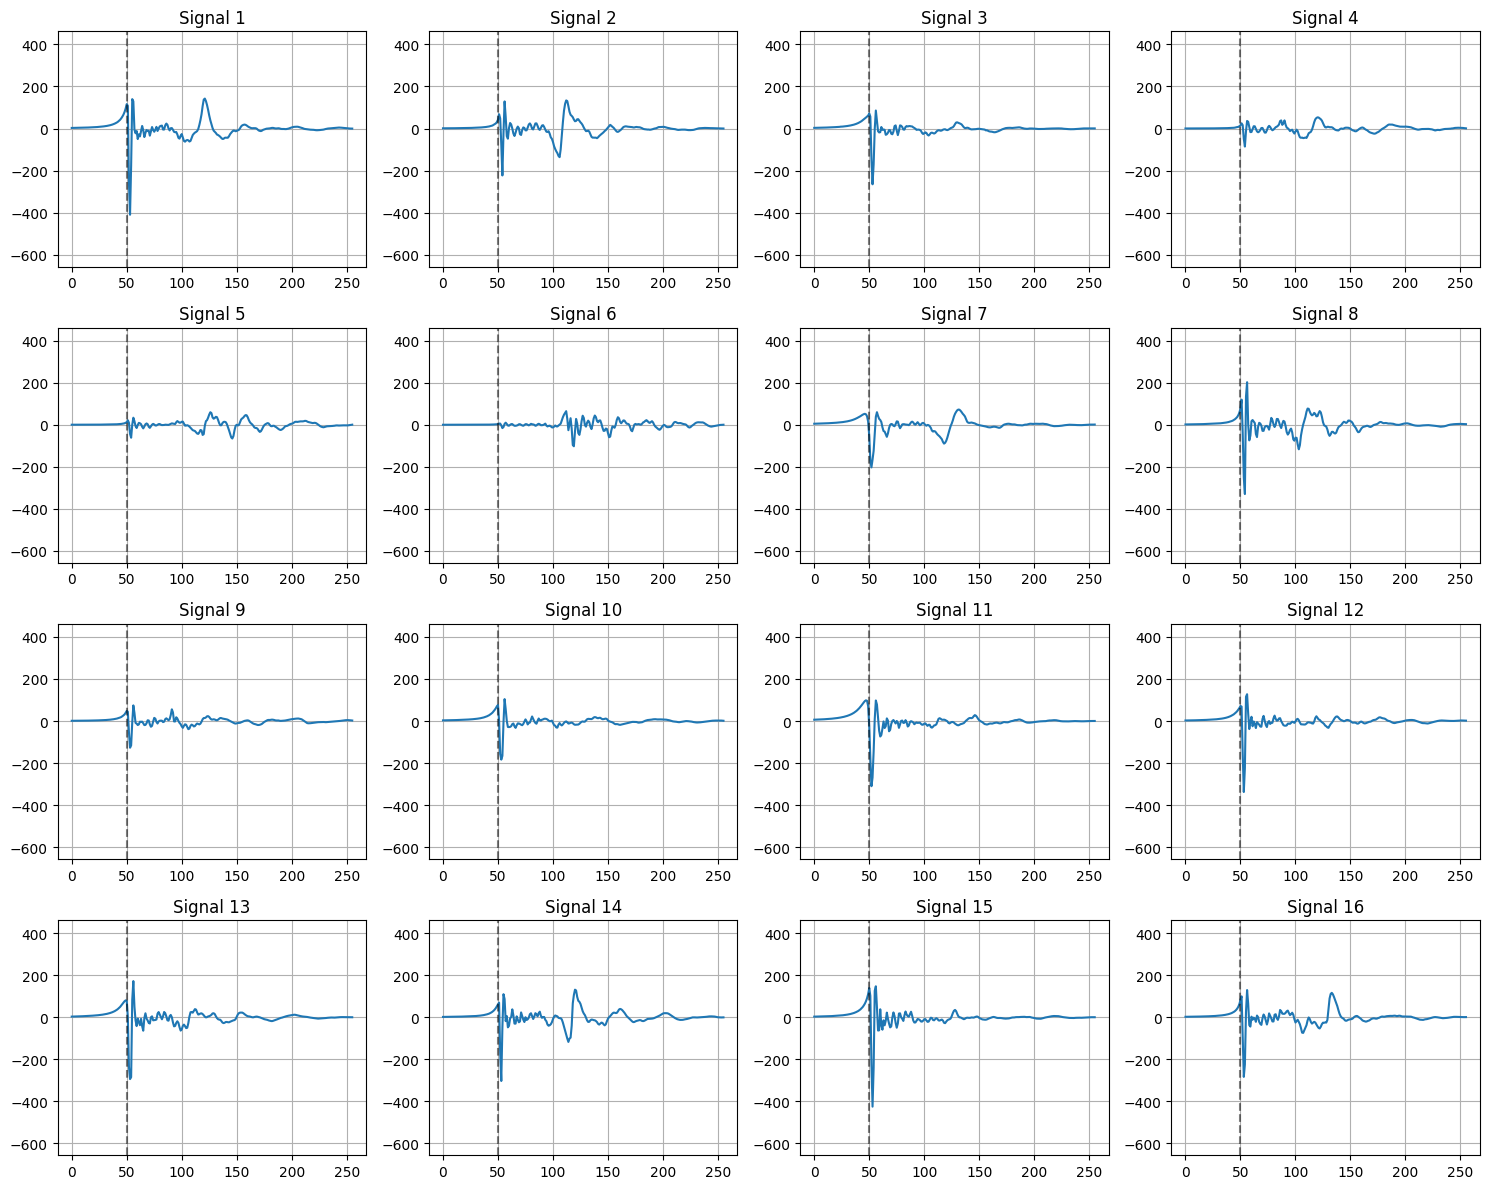

In [78]:
dataset = GWDataset("../data/gw-raw-data/richers_1764.csv", "../data/gw-raw-data/richers_1764_parameters.csv")

common_ylim_signal = dataset.get_common()
dataset.augmentation(6000)
dataset.calc_stats()
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

real_signals_batch, real_parameter_batch  = next(iter(dataloader))

print(real_parameter_batch.shape)

print("Signal Batch Size: ", real_signals_batch.shape)

common_ylim = (real_signals_batch[:,:,:].min(), real_signals_batch[:,:,:].max())
parameter_names = ['beta1_IC_b', 'A(km)', 'omega_0(rad|s)']

plot_waveforms(real_signals_batch, real_parameter_batch)
# plot_waveforms_standardised(real_signals_batch, real_parameter_batch)

In [79]:
dataset.__len__()

6000

### Weight Initialisation (Random Noise)

In [80]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Generator

In [81]:
if (gans_type == 'fccdcgans'):
    class Generator(nn.Module):
        def __init__(self):
            super().__init__()
            self.z_reshape = nn.Sequential(
                nn.Linear(nz, 64),
                nn.LeakyReLU(True)
            )
        
            self.y_reshape = nn.Sequential(
                nn.Linear(num_classes, 10),
                nn.LeakyReLU(True),
            )

            self.main = nn.Sequential(
                nn.ConvTranspose1d(110, ngf * 32, kernel_size=4, stride=1, padding=0, bias=False),
                nn.BatchNorm1d(ngf * 32),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 32, ngf * 16, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 16),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 16, ngf * 8, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 8),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 4),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 2),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False),
            )

        def forward(self, z, y):
            print(z.shape)
            print(y.shape)
            z = torch.reshape(z, (z.shape[0], z.shape[2], z.shape[1]))
            print(z.shape)
            # z = self.z_reshape(z)
            print(z.shape)
            y = torch.reshape(y, (y.shape[0], y.shape[2], y.shape[1]))
            y = self.y_reshape(y)
            print(y.shape)
            z = torch.cat([z, y], 2)
            print(z.shape)
            z = torch.reshape(z, (z.shape[0], z.shape[2], z.shape[1]))
            z = self.main(z)
            print(z.shape)
            return z

if (gans_type == 'cdcgans'):
    class Generator(nn.Module):
        def __init__(self):
            super().__init__()
            self.z_reshape = nn.Sequential(
                nn.ConvTranspose1d(nz, ngf * 16, kernel_size=4, stride=1, padding=0, bias=False),
                nn.LeakyReLU(True)
            )
        
            self.y_reshape = nn.Sequential(
                nn.ConvTranspose1d(num_classes, ngf * 16, kernel_size=4, stride=1, padding=0, bias=False),
                nn.LeakyReLU(True),
            )

            self.main = nn.Sequential(
                # nn.ConvTranspose1d(ngf * 32, ngf * 32, kernel_size=4, stride=2, padding=1, bias=False),
                # nn.BatchNorm1d(ngf * 32),
                # nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 32, ngf * 16, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 16),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 16, ngf * 8, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 8),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 4),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 2),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False),
            )

        def forward(self, z, y):
            # print(z.shape)
            # print(y.shape)
            z = self.z_reshape(z)
            # print(z.shape)
            y = self.y_reshape(y)
            # print(y.shape)
            z = torch.cat([z, y], 1)
            print(z.shape)
            z = self.main(z)
            # print(z.shape)
            return z

if gans_type == 'dcgans':
    class Generator(nn.Module):
        def __init__(self):
            super().__init__()
            self.main = nn.Sequential(
                nn.ConvTranspose1d(nz, ngf * 32, kernel_size=4, stride=1, padding=0, bias=False),
                nn.BatchNorm1d(ngf * 32),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 32, ngf * 16, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 16),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 16, ngf * 8, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 8),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 4),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 2),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False),
            )

        def forward(self, z):
            z = self.main(z)
            return z
        
if gans_type == 'gans':
    class Generator(nn.Module):
        def __init__(self):
            super(Generator, self).__init__()
            self.main = nn.Sequential(
                nn.Linear(nz, ngf),
                nn.BatchNorm1d(ngf),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Linear(ngf, ngf * 2),
                nn.BatchNorm1d(ngf * 2),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Linear(ngf * 2, ngf * 4),
                nn.BatchNorm1d(ngf * 4),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Linear(ngf * 4, ngf * 8),
                nn.BatchNorm1d(ngf * 8),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Linear(ngf * 8, 512),
            )

        def forward(self, z):
            z = z.view(z.size(0), -1)  # Flatten the tensor
            z = self.main(z)
            z = z.view(z.size(0), 1, 512)
            return z

In [82]:
netG = Generator().to(device)

netG.apply(weights_init)

print(netG)

if (gans_type == 'cdcgans' or gans_type == 'fccdcgans'):
    model = Generator()
    summary(netG, input_size=[(nz, nc), (num_classes, 1)])
elif gans_type == 'dcgans' or gans_type == 'gans':
    model = Generator()
    summary(model, input_size=(nz, nc))

Generator(
  (main): Sequential(
    (0): ConvTranspose1d(100, 2048, kernel_size=(4,), stride=(1,), bias=False)
    (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=True)
    (3): ConvTranspose1d(2048, 1024, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=True)
    (6): ConvTranspose1d(1024, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=True)
    (9): ConvTranspose1d(512, 256, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=True)
    (12): ConvTranspose1d(256, 128, kernel_size=(4,), stride=(2,), padding=(1,), bias

### Discriminator

In [83]:
if (gans_type == "fccdcgans"):
    class Discriminator(nn.Module):
        def __init__(self):
            super().__init__()
            self.y_reshape = nn.Sequential(
                nn.Linear(num_classes, 256)
            )

            self.main = nn.Sequential(
                # has same affect as taking in signal with 2 channels
                nn.Conv1d(2, ndf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Conv1d(ndf, ndf * 2, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Conv1d(ndf * 2, ndf * 4, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Conv1d(ndf * 4, ndf * 8, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 16),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Conv1d(ndf * 16, ndf * 32, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 32),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Conv1d(ndf * 32, ndf * 64, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 64),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),
                
                nn.Conv1d(ndf * 64, nc, kernel_size=4,
                        stride=2, padding=0, bias=False)
            )

            self.fc = nn.Sequential(
                nn.LazyLinear(1),
                nn.Dropout(0.2),
                nn.Sigmoid()
            )

        def forward(self, x, y):
            # print(x.shape)
            # print(y.shape)
            x = torch.reshape(x, (x.shape[0], x.shape[2], x.shape[1]))
            # print(x.shape)
            y = torch.reshape(y, (y.shape[0], y.shape[2], y.shape[1]))
            y = self.y_reshape(y)
            # print(y.shape)
            y = torch.reshape(y, (y.shape[0], y.shape[2], y.shape[1]))
            p = torch.cat([x, y], 2)
            p = torch.reshape(p, (p.shape[0], p.shape[2], p.shape[1]))
            # print(p.shape)
            p = self.main(p)
            # print(p.shape)
            p = x.view(p.shape[0], -1)  # Flatten the tensor
            # print(p.shape)
            p = self.fc(p)
            print(p.shape)
            return p

elif (gans_type == "cdcgans"):
    class Discriminator(nn.Module):
        def __init__(self):
            super().__init__()
            self.y_reshape = nn.Sequential(
                nn.Conv1d(num_classes, 256, kernel_size=3, stride=2, padding=1, bias=False)
            )

            self.main = nn.Sequential(
                # convolution takes in 2x size now aftert concatination
                nn.Conv1d(2, ndf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Conv1d(ndf, ndf * 2, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Conv1d(ndf * 2, ndf * 4, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Conv1d(ndf * 4, ndf * 8, kernel_size=4,
                        stride=2, padding=1, bias=False),
                # nn.BatchNorm1d(ndf * 16),
                # nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout(0.2),

                # nn.Conv1d(ndf * 16, ndf * 32, kernel_size=4,
                #         stride=2, padding=1, bias=False),
                # nn.BatchNorm1d(ndf * 32),
                # nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout(0.2),

                # nn.Conv1d(ndf * 32, ndf * 64, kernel_size=4,
                #         stride=2, padding=1, bias=False),
                # nn.BatchNorm1d(ndf * 64),
                # nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout(0.2),
                
                # nn.Conv1d(ndf * 64, nc, kernel_size=4,
                #         stride=2, padding=0, bias=False)
            )

            self.fc = nn.Sequential(
                nn.LazyLinear(1),
                nn.Dropout(0.2),
                nn.Sigmoid()
            )

        def forward(self, x, y):
            print(x.shape)
            print(y.shape)
            # swithc signal dimensions to match parameter dimensions after convolution
            x = torch.reshape(x, (x.shape[0], x.shape[2], x.shape[1]))
            print(x.shape)
            y = self.y_reshape(y)
            print(y.shape)
            p = torch.cat([x, y], 2)
            p = torch.reshape(p, (p.shape[0], p.shape[2], p.shape[1]))
            print(p.shape)
            p = self.main(p)
            print(p.shape)
            p = x.view(p.shape[0], -1)  # Flatten the tensor
            print(p.shape)
            p = self.fc(p)
            print(p.shape)
            return p

elif (gans_type == "dcgans"):
    class Discriminator(nn.Module):
        def __init__(self):
            super(Discriminator, self).__init__()
            self.main = nn.Sequential(
                nn.Conv1d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout1d(0.2),

                nn.Conv1d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout1d(0.2),

                nn.Conv1d(ndf * 2, ndf * 4, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout1d(0.2),

                nn.Conv1d(ndf * 4, ndf * 8, kernel_size=4,
                        stride=2, padding=0, bias=False),
                nn.BatchNorm1d(ndf * 8),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout1d(0.2),

                ### Can increase model complexity here ###
                # nn.Conv1d(ndf * 8, ndf * 16, kernel_size=4,
                #         stride=2, padding=1, bias=False),
                # nn.BatchNorm1d(ndf * 16),
                # nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout1d(0.2),

                # nn.Conv1d(ndf * 16, ndf * 32, kernel_size=4,
                #         stride=2, padding=1, bias=False),
                # nn.BatchNorm1d(ndf * 32),
                # nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout1d(0.2),

                # nn.Conv1d(ndf * 32, nc, kernel_size=4,
                #         stride=2, padding=1, bias=False),
                # nn.BatchNorm1d(ndf * 64),
                # nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout1d(0.2),
                
                # nn.Conv1d(ndf * 64, nc, kernel_size=4,
                #         stride=2, padding=0, bias=False)
            )

            self.fc = nn.Sequential(
                nn.LazyLinear(1),
                nn.Dropout(0.2),
                nn.Sigmoid()
            )

        def forward(self, x):
            x = self.main(x)
            x = x.view(x.shape[0], -1)  # Flatten the tensor
            x = self.fc(x)
            return x

elif (gans_type == "gans"):
    class Discriminator(nn.Module):
        def __init__(self):
            super(Discriminator, self).__init__()
            self.main = nn.Sequential(
                nn.Linear(512, 256),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Linear(256, 128),
                # nn.BatchNorm1d(128),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Linear(128, 64),
                # nn.BatchNorm1d(64),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Linear(64, 32),
                # nn.BatchNorm1d(32),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Linear(32, 16),
                # nn.BatchNorm1d(16),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Linear(16, 1),
                nn.Sigmoid(),
            )

        def forward(self, x):
            x = x.view(x.size(0), -1)  # Flatten the tensor
            x = self.main(x)
            return x

In [84]:
netD = Discriminator().to(device)

netD.apply(weights_init)

print(netD)

if (gans_type == "cdcgans" or gans_type == "fccdcgans"):
    model = Discriminator()
    summary(model, input_size=[(nc, 256), (num_classes, 1)])
elif gans_type == 'dcgans' or gans_type == 'gans':
    model = Discriminator()
    summary(model, input_size=(nc, 256))

Discriminator(
  (main): Sequential(
    (0): Conv1d(1, 64, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout1d(p=0.2, inplace=False)
    (3): Conv1d(64, 128, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout1d(p=0.2, inplace=False)
    (7): Conv1d(128, 256, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (8): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Dropout1d(p=0.2, inplace=False)
    (11): Conv1d(256, 512, kernel_size=(4,), stride=(2,), bias=False)
    (12): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): Dropout1d(p=0.2, inplace=False

/Users/tarineccleston/Documents/software-ds/gw-generative-models/.venv/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Loss functions and Optimisers

In [85]:
criterion = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))

# learning-rate decay scheduler
schedulerD = lr_scheduler.LinearLR(optimizerD, start_factor=1.0, end_factor=0.5, total_iters=30)
schedulerG = lr_scheduler.LinearLR(optimizerG, start_factor=1.0, end_factor=0.5, total_iters=30)

# establish convention for real and fake labels during training
real_label = 1.0
fake_label = 0.0

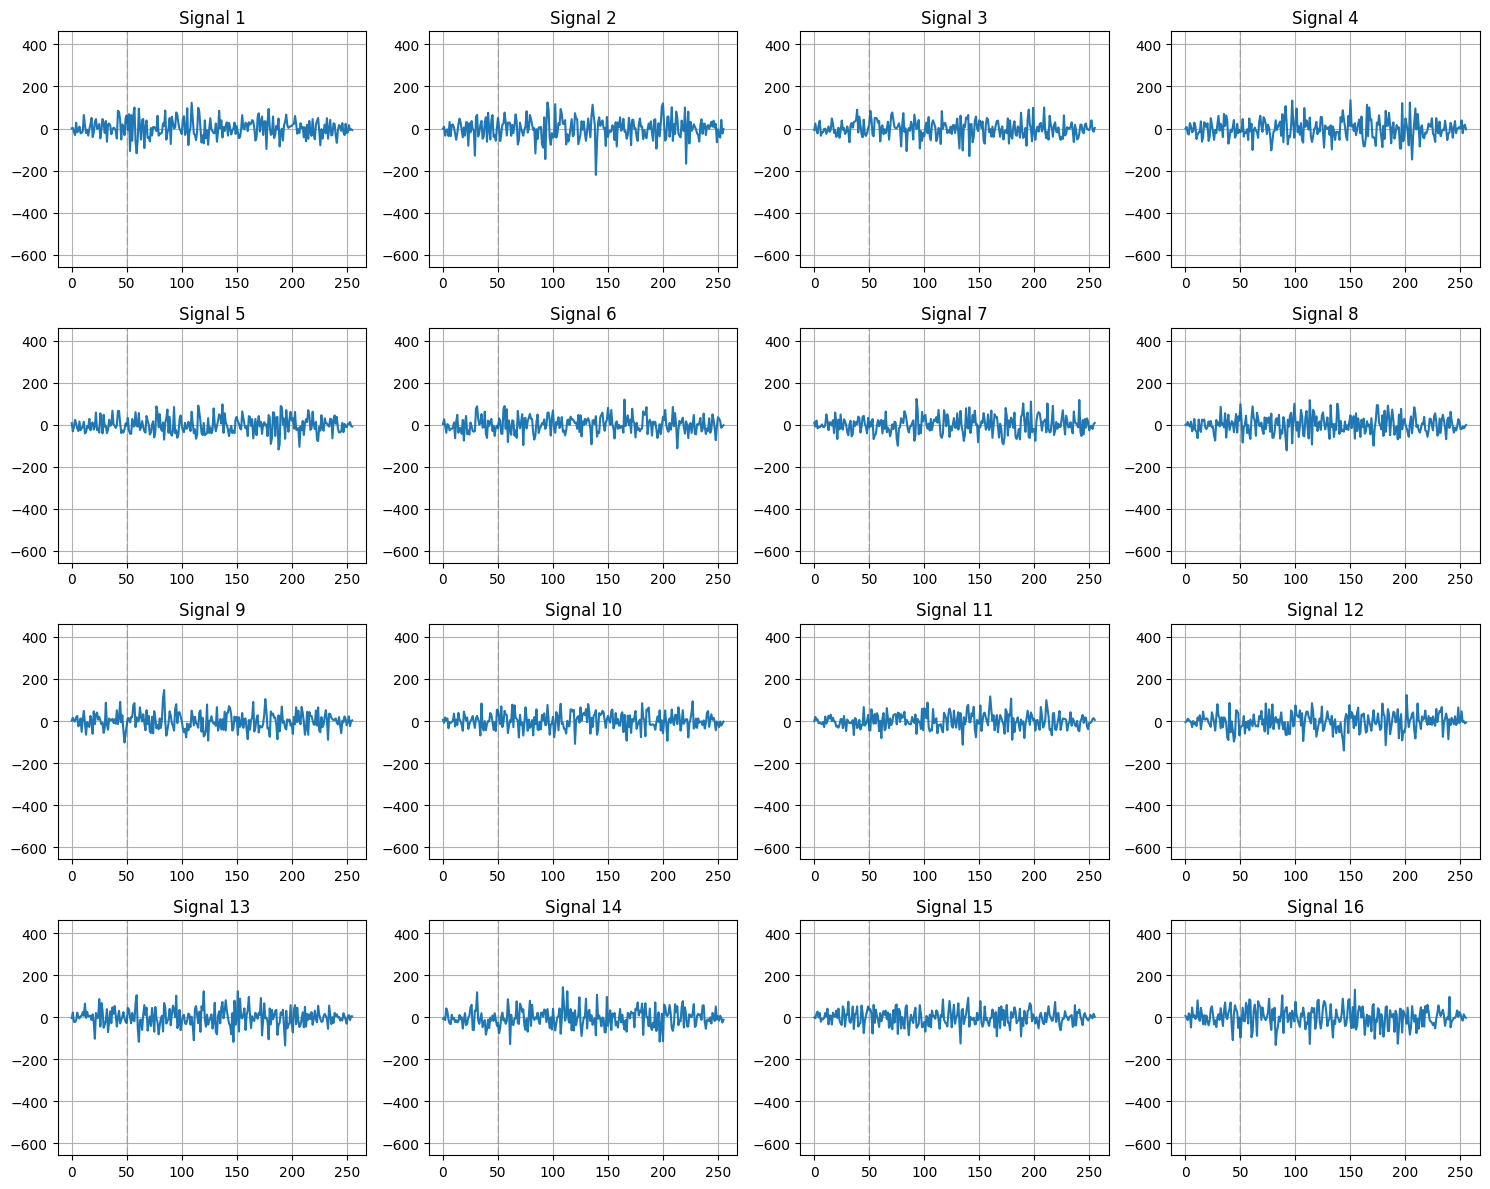

In [86]:
# create batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(batch_size, nz, 1, device=device)
# fixed_parameter_noise = torch.randn(batch_size, num_classes, 1, device=device)

fixed_random_indices = torch.randint(0, num_classes, (batch_size,)).long()
# create a one-hot encoding from the random indices
fixed_random_one_hot_encoding = torch.nn.functional.one_hot(fixed_random_indices, num_classes=num_classes).float()
fixed_random_one_hot_encoding = fixed_random_one_hot_encoding.unsqueeze(-1)

# plot generated signals before training
with torch.no_grad():
    if (gans_type == 'cdcgans' or gans_type == 'fccdcgans'):
        fake_signals = netG(fixed_noise, fixed_random_one_hot_encoding).detach().cpu()
    else:
        fake_signals = netG(fixed_noise).detach().cpu()
    fig, axes = plt.subplots(4, 4, figsize=(15, 12))

    axes = axes.flatten()

    # plot each signal on a separate subplot
    for i, ax in enumerate(axes):
        x = np.arange(fake_signals.size(dim=2))
        y = fake_signals[i, :, :].flatten()
        y = y * dataset.scaling_factor
        y = y * dataset.std + dataset.mean
        ax.plot(x, y)

        ax.axvline(x=50, color='black', linestyle='--', alpha=0.1)
        ax.set_title(f'Signal {i+1}')
        ax.grid(True)
        ax.set_ylim(common_ylim_signal)

    for i in range(512, 8*4):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.savefig('../data/gw-dcgans-images/gw-dcgans_epoch_0.png')
    plt.show()

### Training

Starting Training Loop...
[0/32][0/188]	Loss_D: 1.2679	Loss_G: 0.7735	D(x): 0.5584	D(G(z)): 0.4685 / 0.4742
[0/32][50/188]	Loss_D: 0.7698	Loss_G: 1.1016	D(x): 0.8012	D(G(z)): 0.3395 / 0.3535
[0/32][100/188]	Loss_D: 0.7726	Loss_G: 1.4342	D(x): 0.7968	D(G(z)): 0.2942 / 0.3102
[0/32][150/188]	Loss_D: 0.6745	Loss_G: 1.4854	D(x): 0.8661	D(G(z)): 0.2575 / 0.2984
Epoch 0: SGD Discriminator lr 0.0000200 -> 0.0000197
Epoch 0: SGD Generator lr 0.0000200 -> 0.0000197


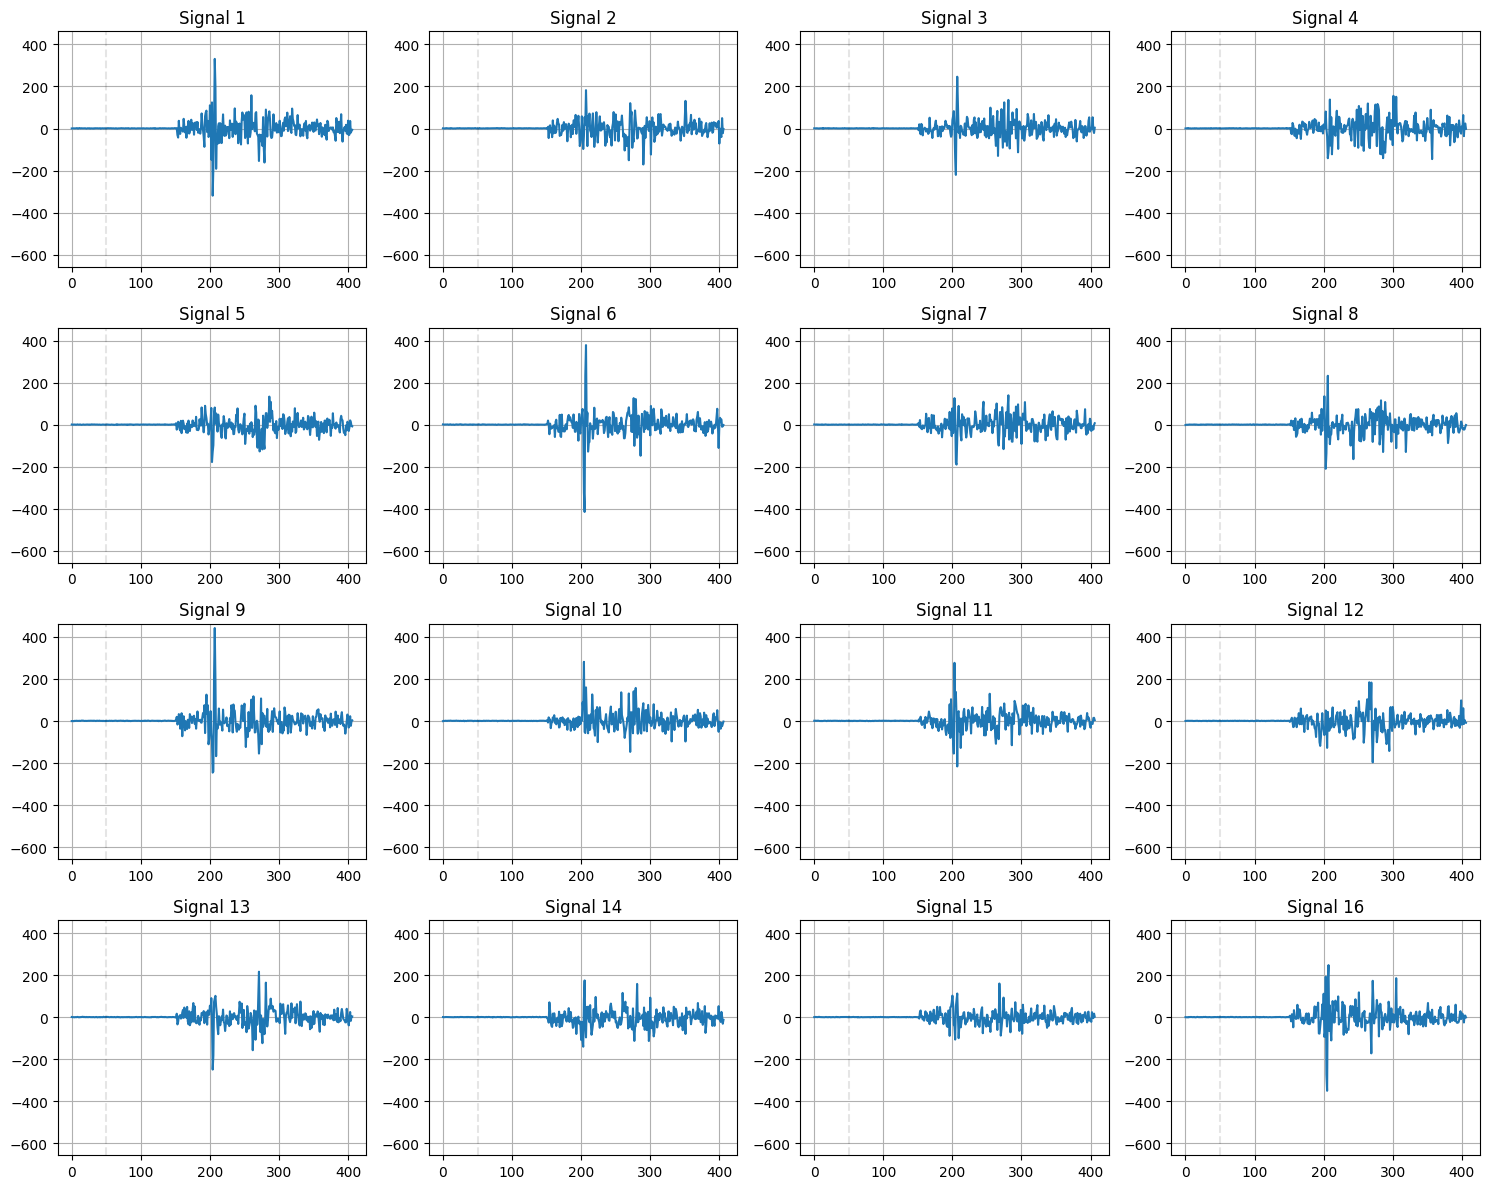

[1/32][0/188]	Loss_D: 0.8043	Loss_G: 1.7239	D(x): 0.7769	D(G(z)): 0.2554 / 0.2275
[1/32][50/188]	Loss_D: 0.7795	Loss_G: 1.5602	D(x): 0.8252	D(G(z)): 0.3189 / 0.2915
[1/32][100/188]	Loss_D: 0.6355	Loss_G: 1.7475	D(x): 0.8848	D(G(z)): 0.2739 / 0.2352
[1/32][150/188]	Loss_D: 0.7801	Loss_G: 1.7694	D(x): 0.7678	D(G(z)): 0.2184 / 0.2305
Epoch 1: SGD Discriminator lr 0.0000197 -> 0.0000193
Epoch 1: SGD Generator lr 0.0000197 -> 0.0000193


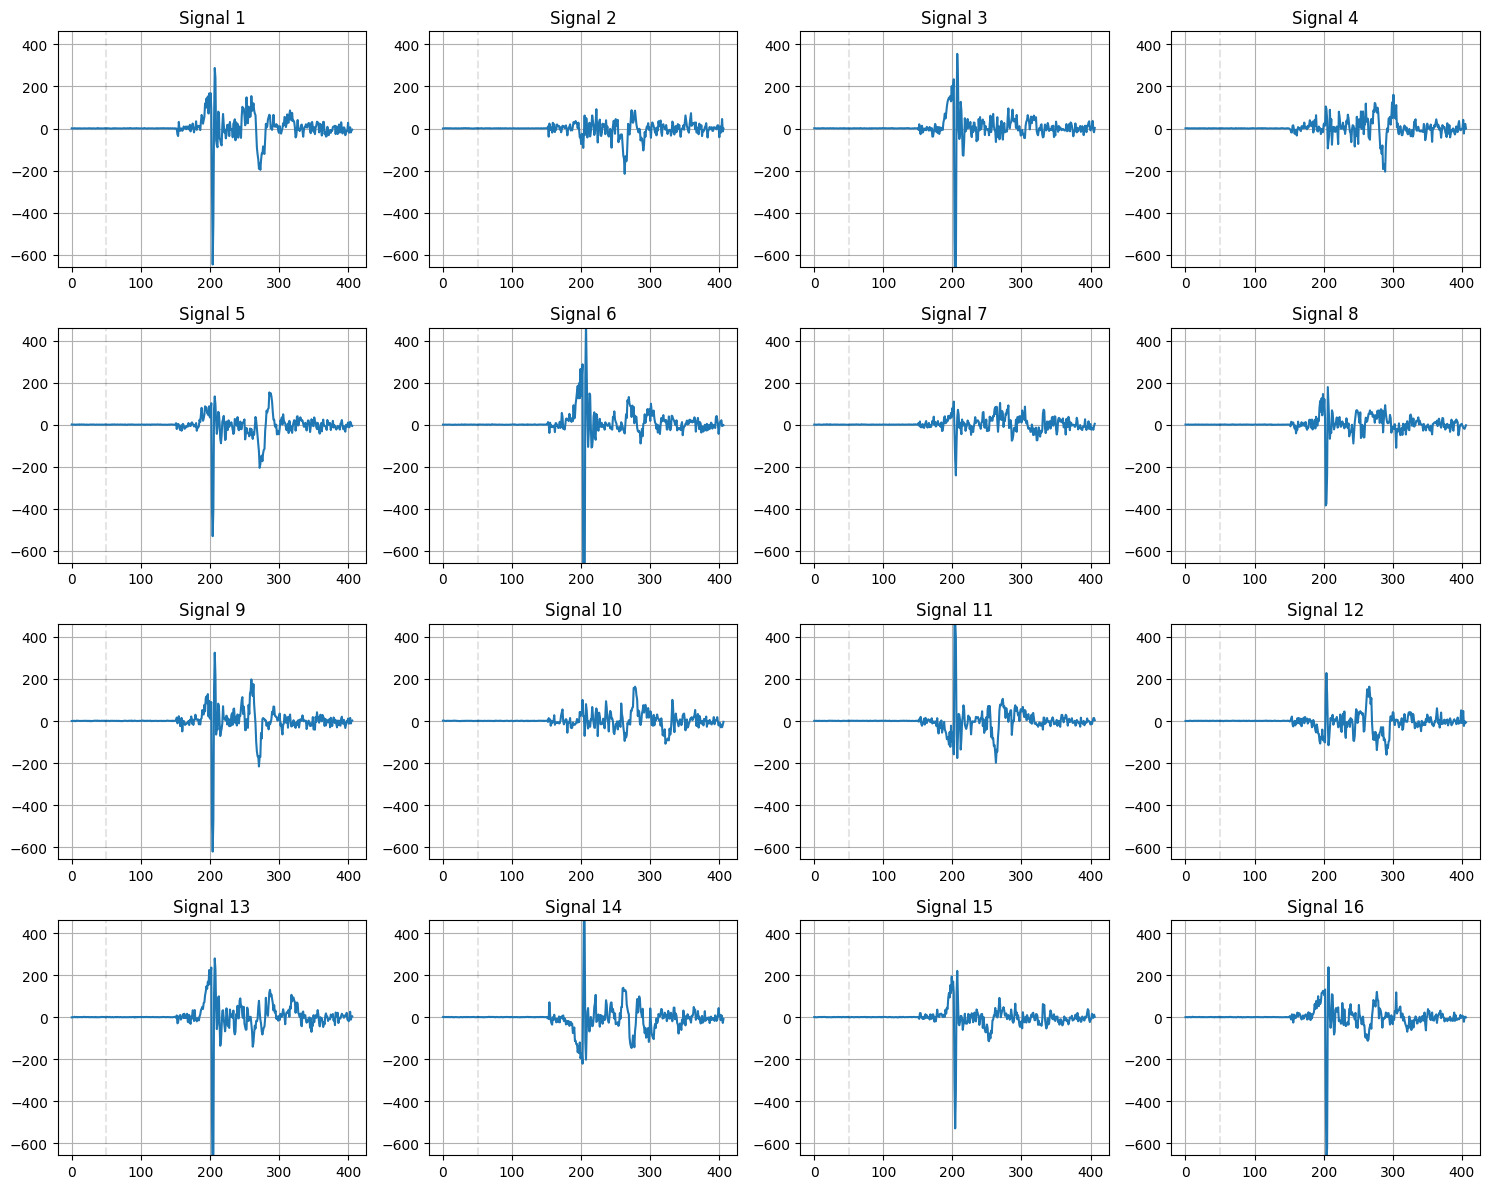

[2/32][0/188]	Loss_D: 0.7495	Loss_G: 1.8307	D(x): 0.8116	D(G(z)): 0.2541 / 0.2266
[2/32][50/188]	Loss_D: 0.5983	Loss_G: 1.6201	D(x): 0.9036	D(G(z)): 0.2136 / 0.2697
[2/32][100/188]	Loss_D: 0.7023	Loss_G: 1.6316	D(x): 0.8203	D(G(z)): 0.2449 / 0.2494
[2/32][150/188]	Loss_D: 0.7453	Loss_G: 1.5996	D(x): 0.8308	D(G(z)): 0.3346 / 0.2480
Epoch 2: SGD Discriminator lr 0.0000193 -> 0.0000190
Epoch 2: SGD Generator lr 0.0000193 -> 0.0000190


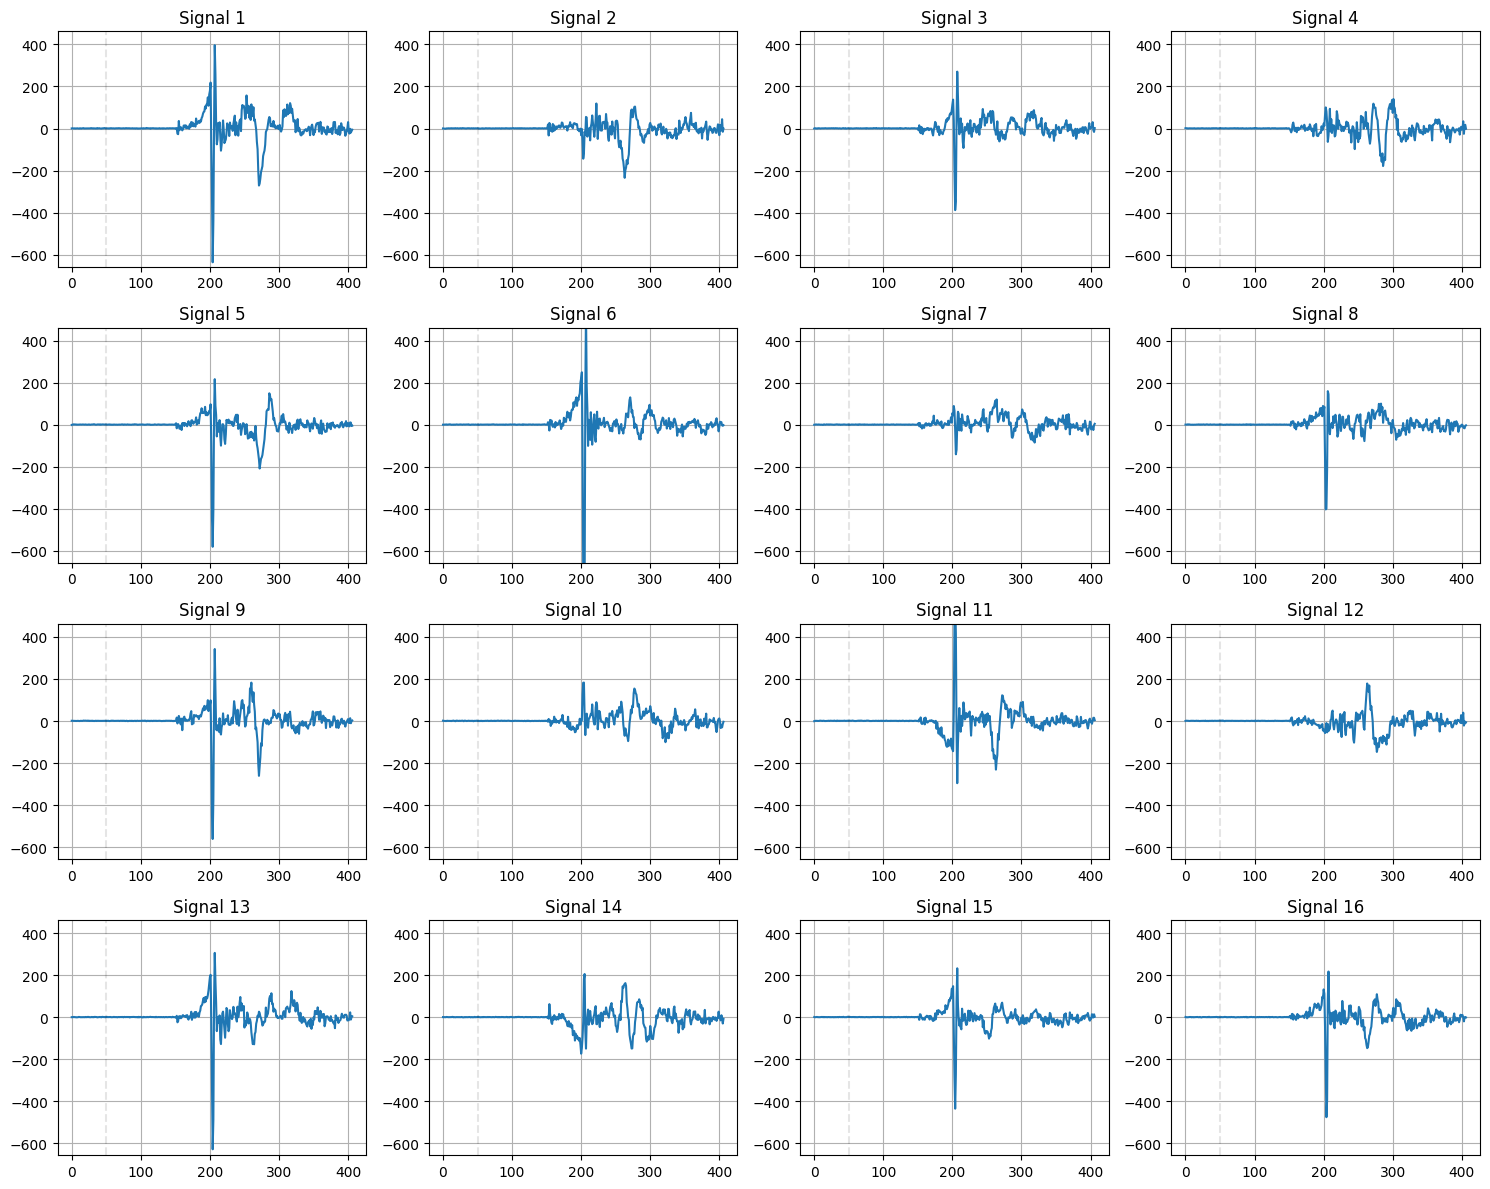

[3/32][0/188]	Loss_D: 0.7365	Loss_G: 1.5495	D(x): 0.8331	D(G(z)): 0.2760 / 0.2695
[3/32][50/188]	Loss_D: 0.6386	Loss_G: 1.8985	D(x): 0.8601	D(G(z)): 0.2235 / 0.2039
[3/32][100/188]	Loss_D: 0.7289	Loss_G: 2.1418	D(x): 0.8434	D(G(z)): 0.2163 / 0.1629
[3/32][150/188]	Loss_D: 0.7182	Loss_G: 1.6576	D(x): 0.8777	D(G(z)): 0.3082 / 0.2376
Epoch 3: SGD Discriminator lr 0.0000190 -> 0.0000187
Epoch 3: SGD Generator lr 0.0000190 -> 0.0000187


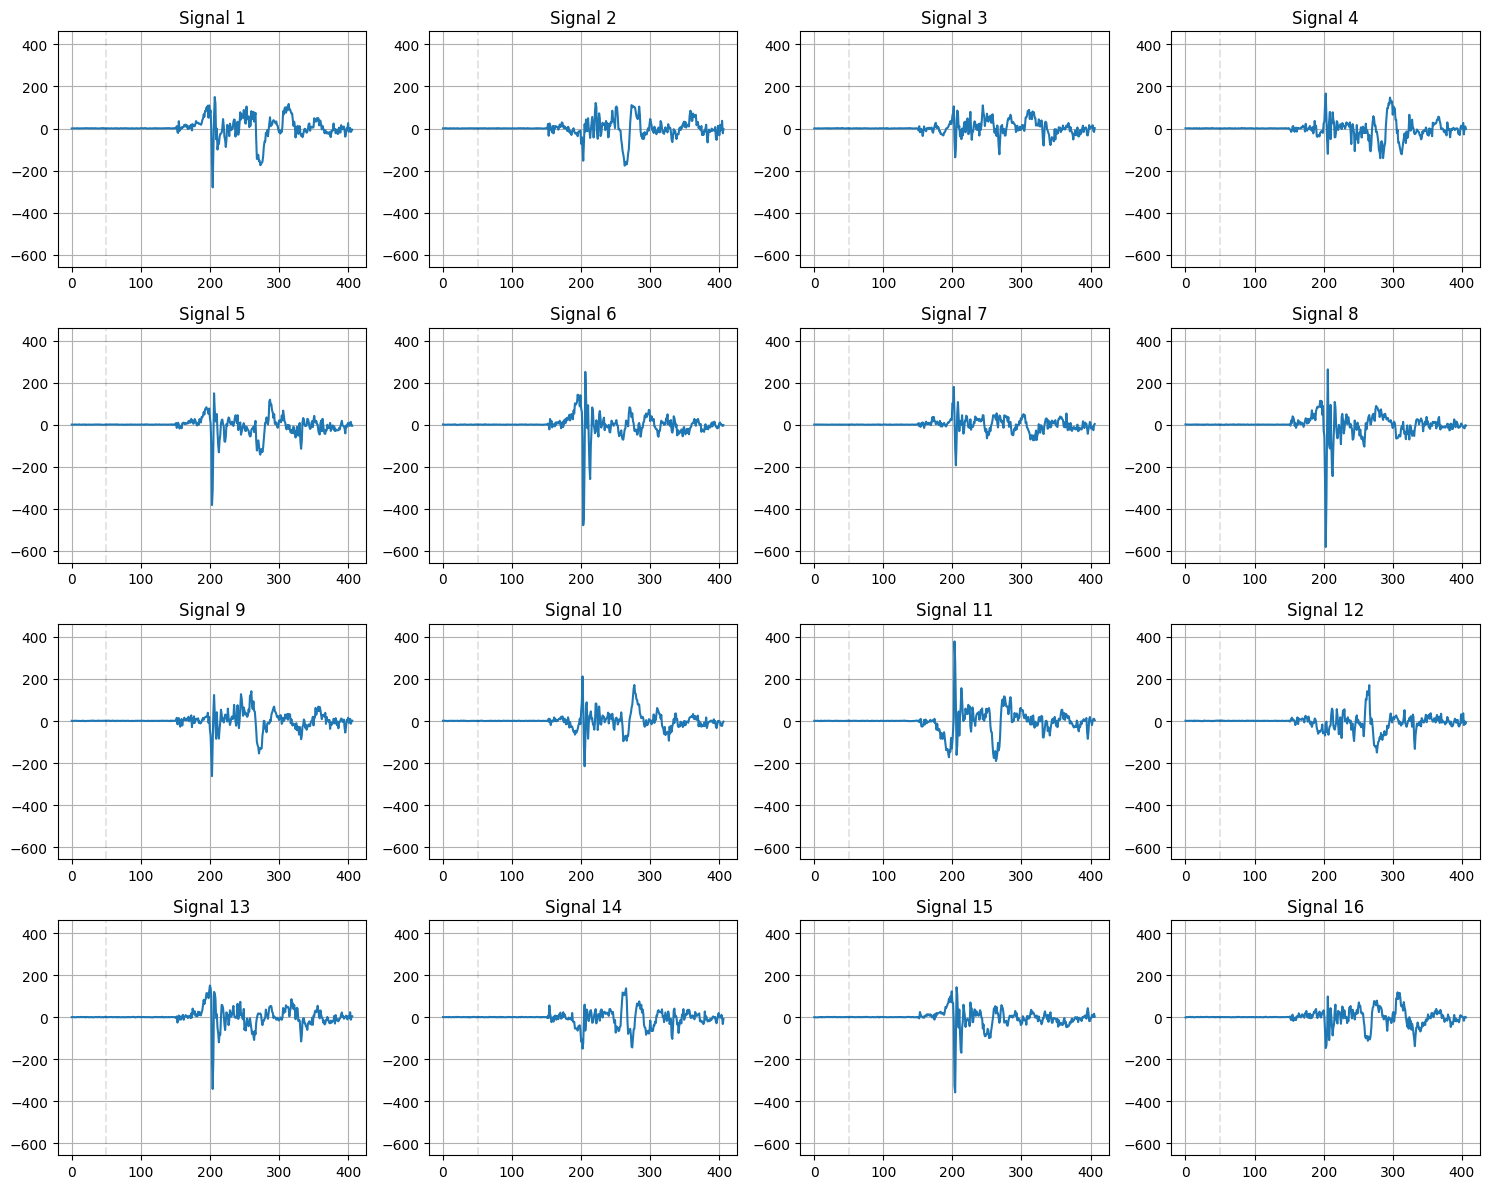

[4/32][0/188]	Loss_D: 0.6239	Loss_G: 1.7574	D(x): 0.8786	D(G(z)): 0.1464 / 0.2559
[4/32][50/188]	Loss_D: 0.6936	Loss_G: 1.8636	D(x): 0.8507	D(G(z)): 0.2516 / 0.2166
[4/32][100/188]	Loss_D: 0.6605	Loss_G: 1.9358	D(x): 0.8809	D(G(z)): 0.2507 / 0.2611
[4/32][150/188]	Loss_D: 0.7651	Loss_G: 1.5627	D(x): 0.8494	D(G(z)): 0.3138 / 0.2933
Epoch 4: SGD Discriminator lr 0.0000187 -> 0.0000183
Epoch 4: SGD Generator lr 0.0000187 -> 0.0000183


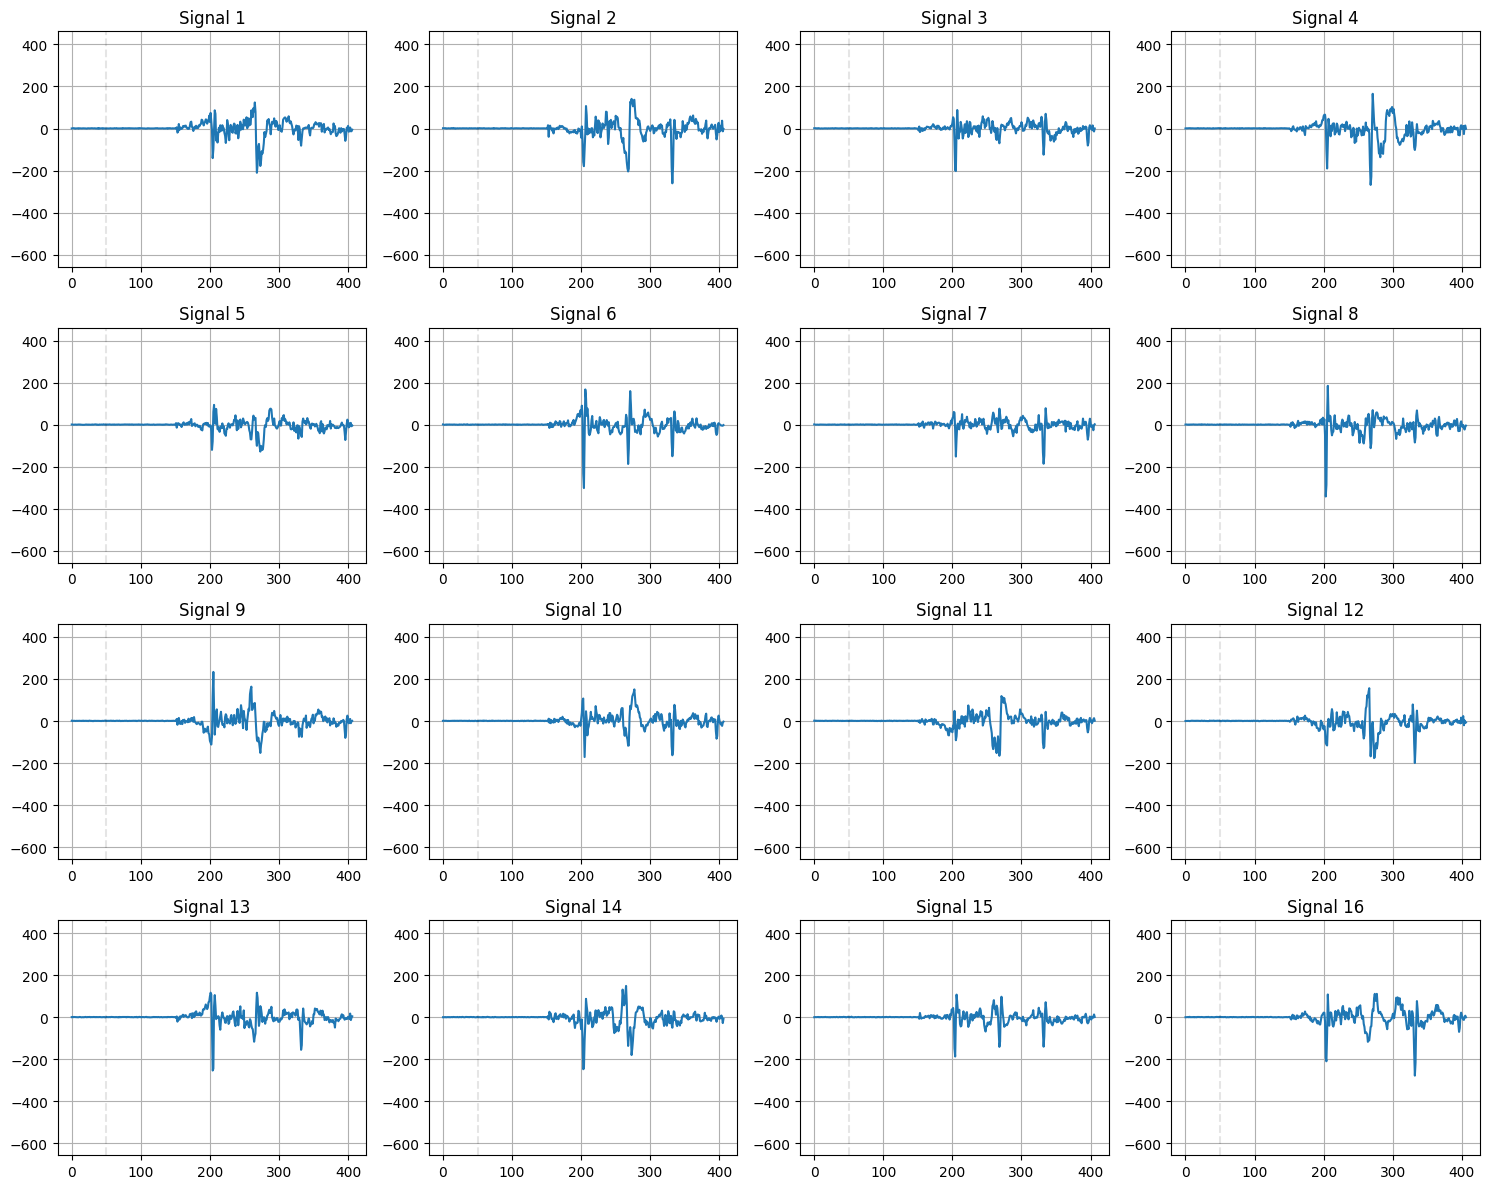

[5/32][0/188]	Loss_D: 0.7509	Loss_G: 2.0387	D(x): 0.8582	D(G(z)): 0.2731 / 0.2194
[5/32][50/188]	Loss_D: 0.5902	Loss_G: 1.8557	D(x): 0.8986	D(G(z)): 0.1919 / 0.2260
[5/32][100/188]	Loss_D: 0.6875	Loss_G: 1.7650	D(x): 0.8484	D(G(z)): 0.2405 / 0.2892
[5/32][150/188]	Loss_D: 0.6601	Loss_G: 2.3433	D(x): 0.8426	D(G(z)): 0.1434 / 0.1965
Epoch 5: SGD Discriminator lr 0.0000183 -> 0.0000180
Epoch 5: SGD Generator lr 0.0000183 -> 0.0000180


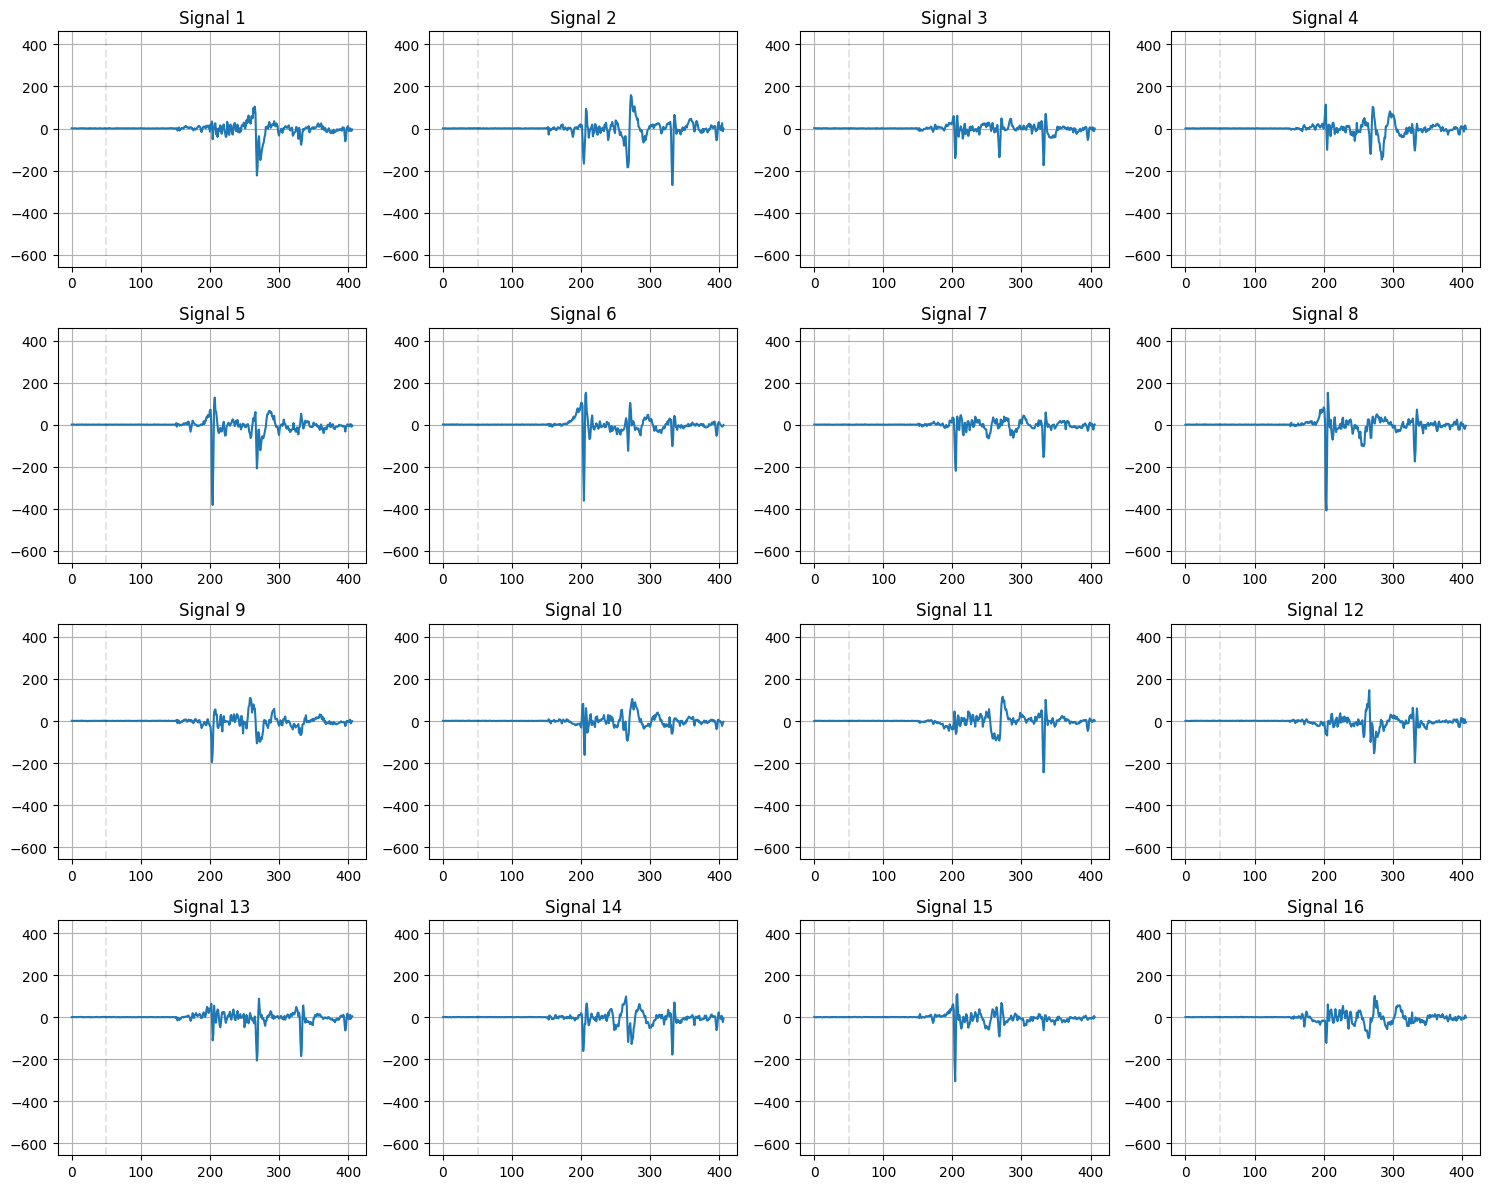

[6/32][0/188]	Loss_D: 0.6594	Loss_G: 1.7395	D(x): 0.8631	D(G(z)): 0.2313 / 0.2571
[6/32][50/188]	Loss_D: 0.8533	Loss_G: 1.4102	D(x): 0.8279	D(G(z)): 0.3620 / 0.3208
[6/32][100/188]	Loss_D: 0.7394	Loss_G: 1.7841	D(x): 0.8273	D(G(z)): 0.2316 / 0.2715
[6/32][150/188]	Loss_D: 0.6699	Loss_G: 2.0962	D(x): 0.8369	D(G(z)): 0.1971 / 0.2039
Epoch 6: SGD Discriminator lr 0.0000180 -> 0.0000177
Epoch 6: SGD Generator lr 0.0000180 -> 0.0000177


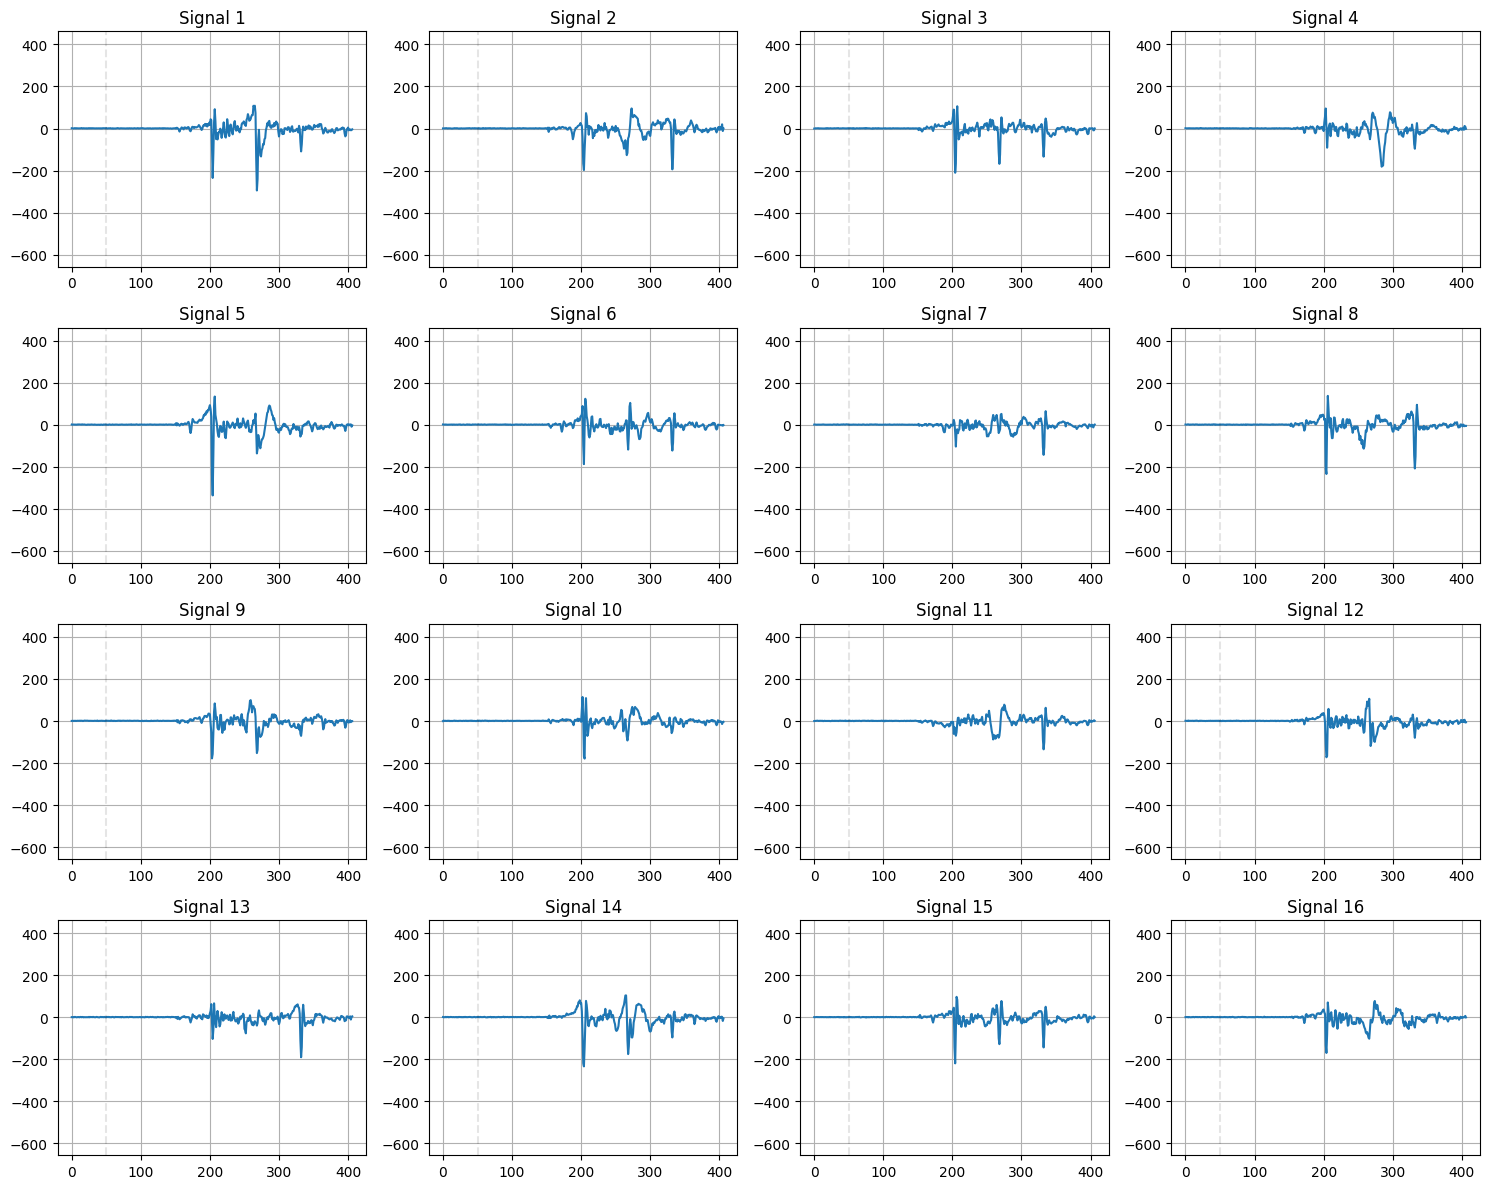

[7/32][0/188]	Loss_D: 0.7192	Loss_G: 1.4925	D(x): 0.8666	D(G(z)): 0.2443 / 0.3421
[7/32][50/188]	Loss_D: 0.6579	Loss_G: 1.5000	D(x): 0.8875	D(G(z)): 0.2896 / 0.3077
[7/32][100/188]	Loss_D: 0.8199	Loss_G: 1.3206	D(x): 0.8439	D(G(z)): 0.3656 / 0.3313
[7/32][150/188]	Loss_D: 0.7632	Loss_G: 2.3216	D(x): 0.7982	D(G(z)): 0.2155 / 0.1793
Epoch 7: SGD Discriminator lr 0.0000177 -> 0.0000173
Epoch 7: SGD Generator lr 0.0000177 -> 0.0000173


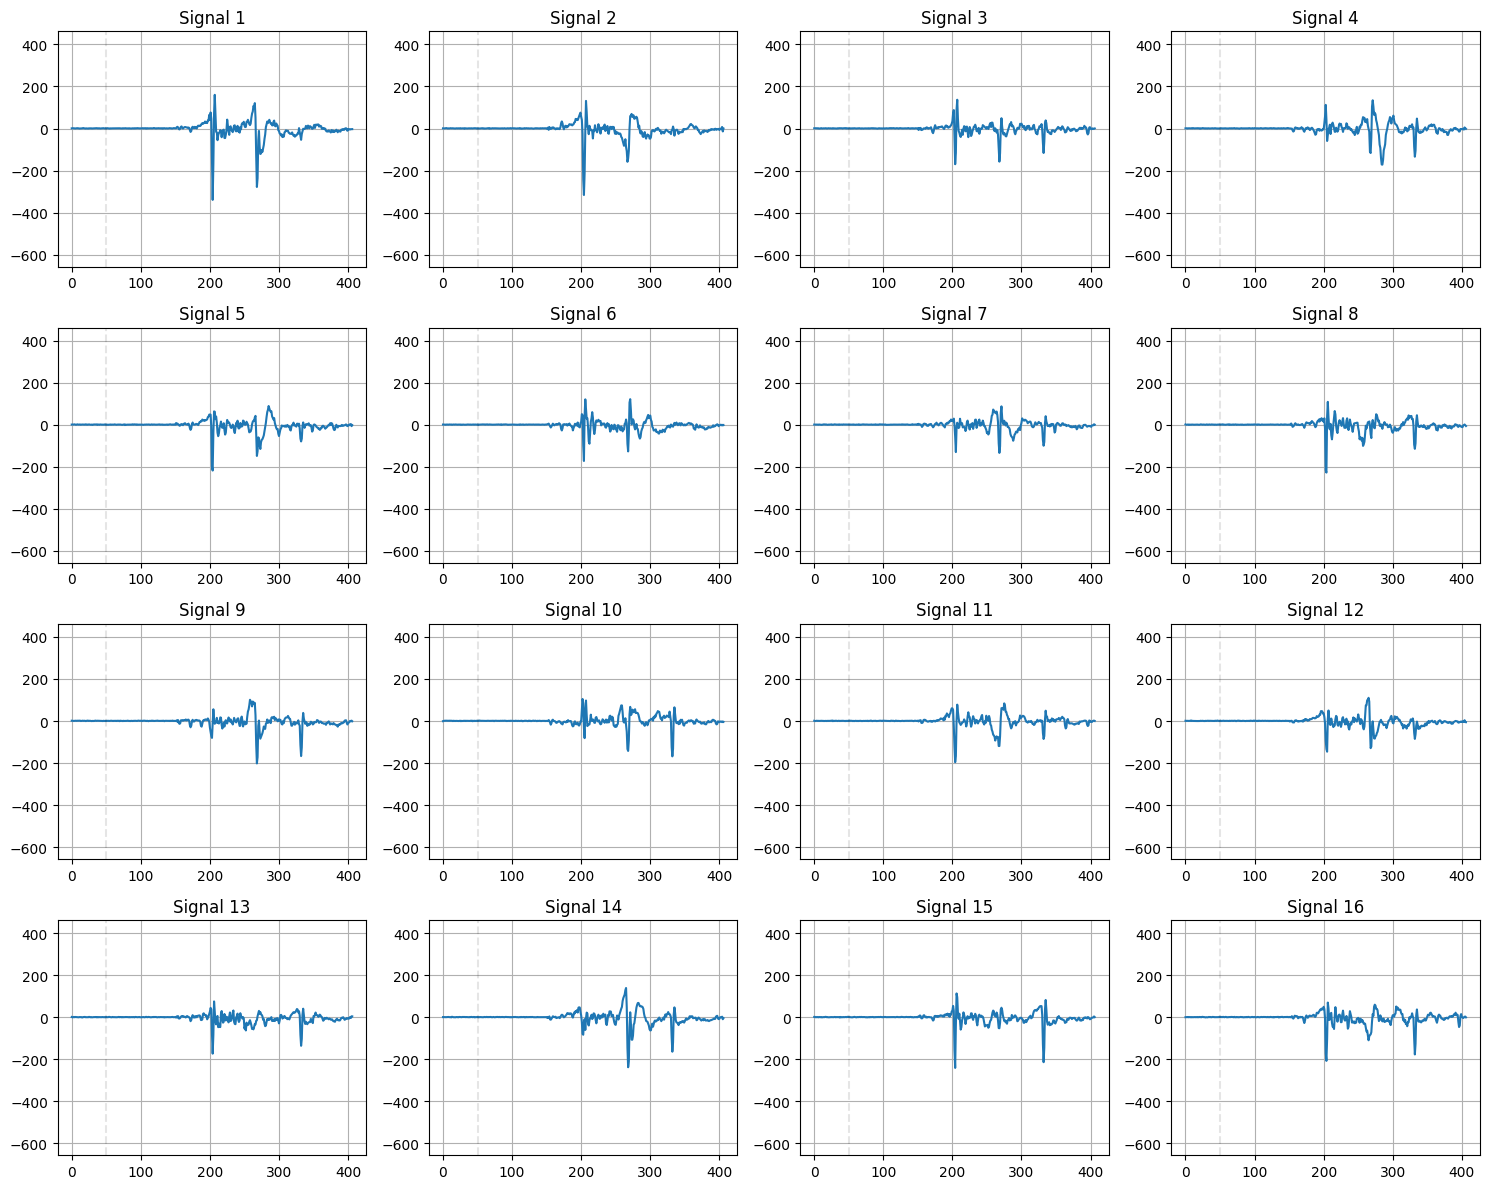

[8/32][0/188]	Loss_D: 0.8048	Loss_G: 2.2911	D(x): 0.8136	D(G(z)): 0.2490 / 0.1668
[8/32][50/188]	Loss_D: 0.7101	Loss_G: 1.8553	D(x): 0.7976	D(G(z)): 0.2376 / 0.2284
[8/32][100/188]	Loss_D: 0.6028	Loss_G: 1.8139	D(x): 0.8842	D(G(z)): 0.1911 / 0.2299
[8/32][150/188]	Loss_D: 0.6611	Loss_G: 1.8213	D(x): 0.8419	D(G(z)): 0.2225 / 0.2372
Epoch 8: SGD Discriminator lr 0.0000173 -> 0.0000170
Epoch 8: SGD Generator lr 0.0000173 -> 0.0000170


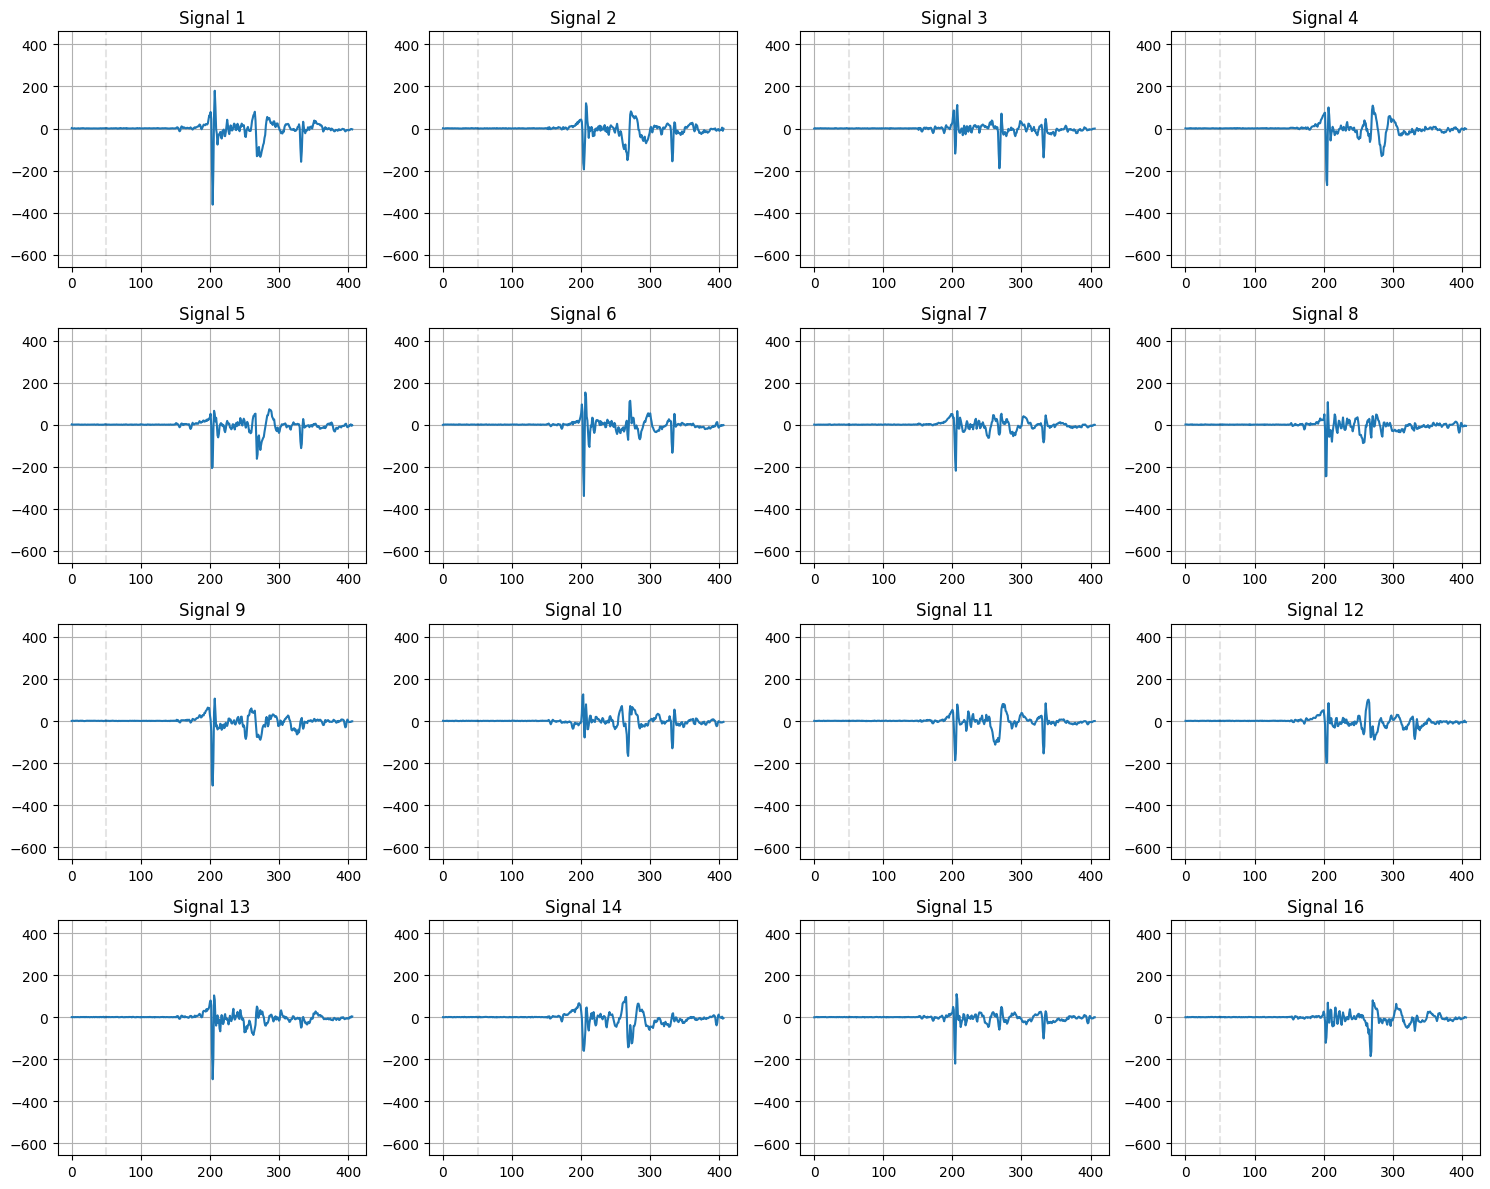

[9/32][0/188]	Loss_D: 0.6657	Loss_G: 2.5707	D(x): 0.8564	D(G(z)): 0.1581 / 0.1733
[9/32][50/188]	Loss_D: 0.7586	Loss_G: 1.8391	D(x): 0.7978	D(G(z)): 0.2512 / 0.2222
[9/32][100/188]	Loss_D: 0.7631	Loss_G: 2.2095	D(x): 0.8126	D(G(z)): 0.2481 / 0.1866
[9/32][150/188]	Loss_D: 0.7795	Loss_G: 1.6243	D(x): 0.8012	D(G(z)): 0.2396 / 0.2706
Epoch 9: SGD Discriminator lr 0.0000170 -> 0.0000167
Epoch 9: SGD Generator lr 0.0000170 -> 0.0000167


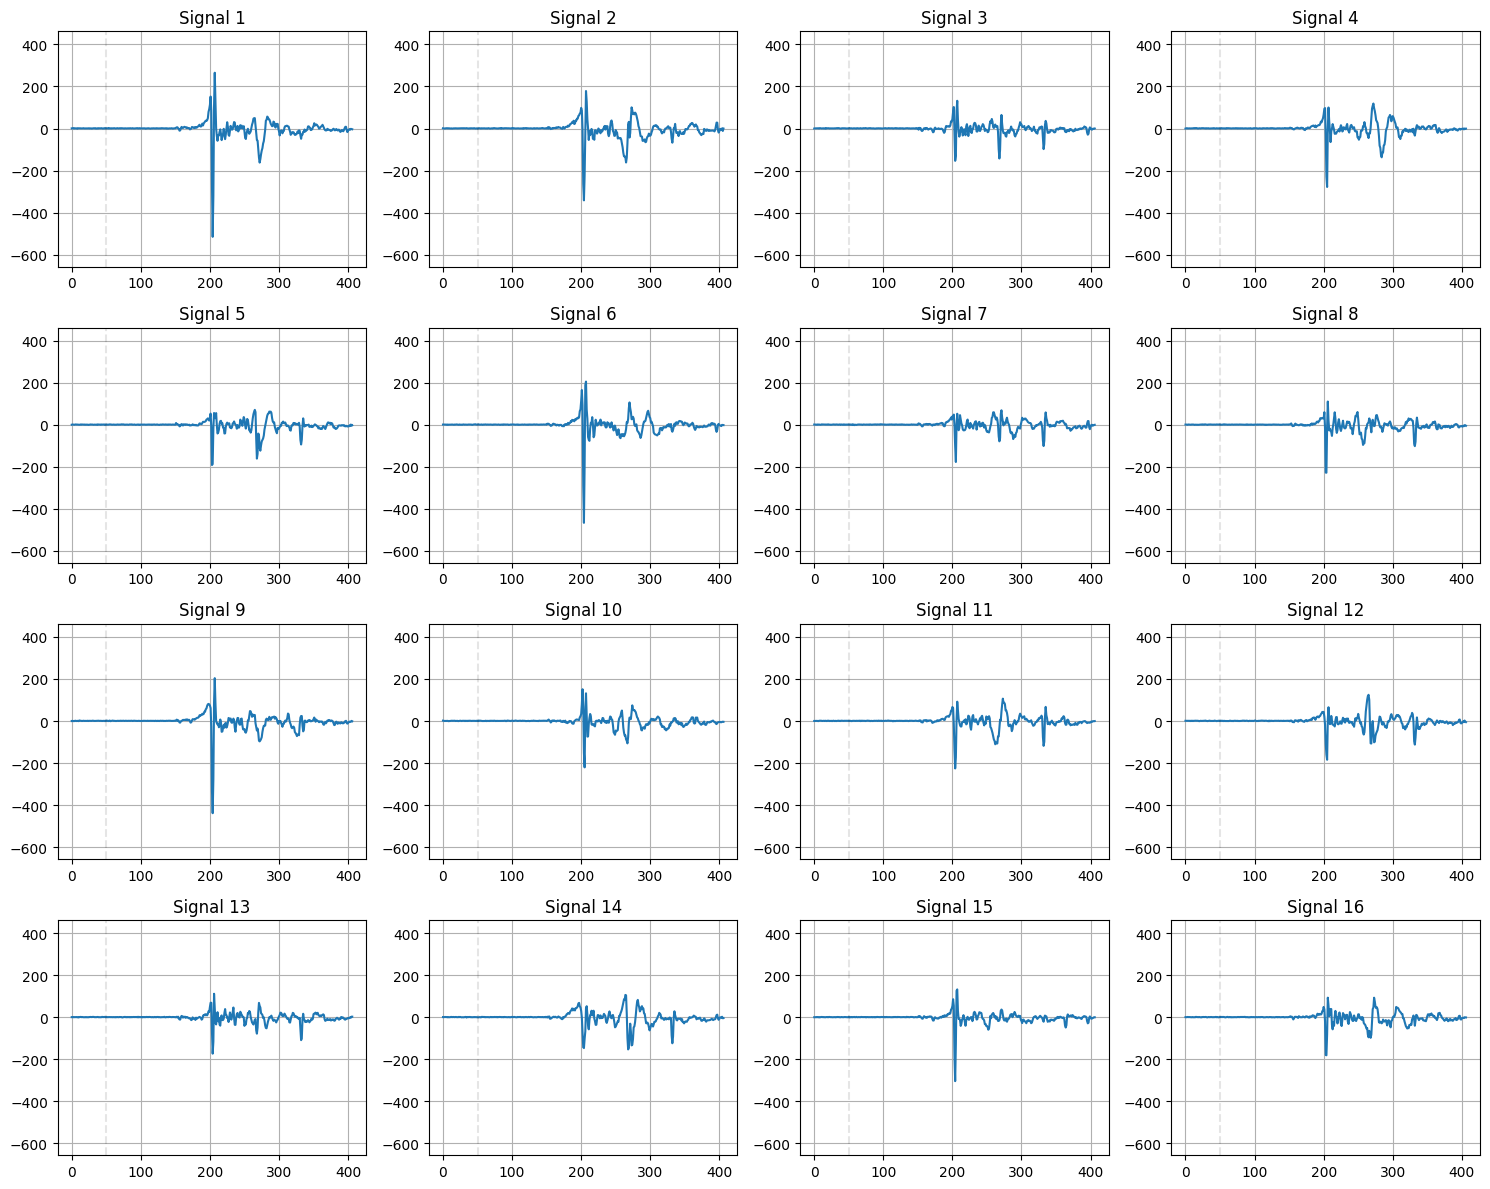

[10/32][0/188]	Loss_D: 0.6114	Loss_G: 1.8375	D(x): 0.8954	D(G(z)): 0.2505 / 0.2248
[10/32][50/188]	Loss_D: 0.7172	Loss_G: 1.6329	D(x): 0.8507	D(G(z)): 0.2438 / 0.2547
[10/32][100/188]	Loss_D: 0.5698	Loss_G: 2.0282	D(x): 0.9018	D(G(z)): 0.2207 / 0.2083
[10/32][150/188]	Loss_D: 0.6076	Loss_G: 1.5081	D(x): 0.8818	D(G(z)): 0.2621 / 0.3012
Epoch 10: SGD Discriminator lr 0.0000167 -> 0.0000163
Epoch 10: SGD Generator lr 0.0000167 -> 0.0000163


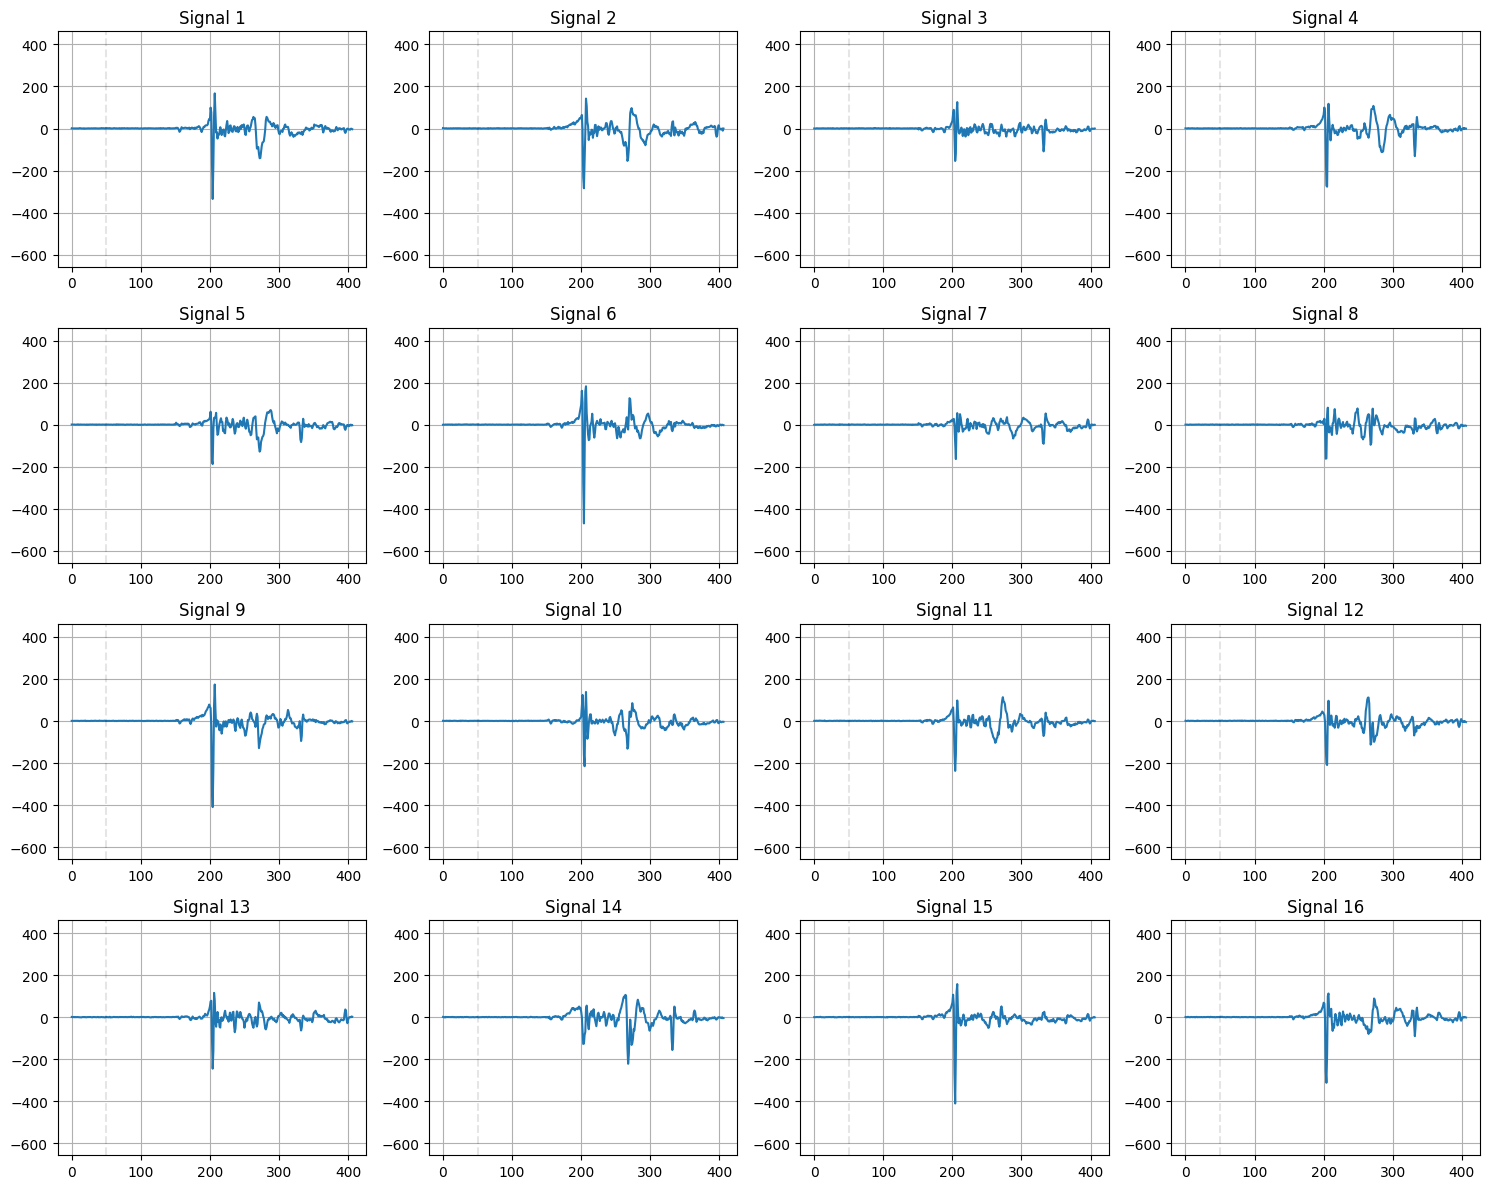

[11/32][0/188]	Loss_D: 0.6657	Loss_G: 1.5674	D(x): 0.8836	D(G(z)): 0.2214 / 0.2567
[11/32][50/188]	Loss_D: 0.5914	Loss_G: 1.7175	D(x): 0.8894	D(G(z)): 0.2462 / 0.2550
[11/32][100/188]	Loss_D: 0.7229	Loss_G: 1.5100	D(x): 0.8307	D(G(z)): 0.2495 / 0.2760
[11/32][150/188]	Loss_D: 0.8263	Loss_G: 1.9778	D(x): 0.8027	D(G(z)): 0.2153 / 0.2210
Epoch 11: SGD Discriminator lr 0.0000163 -> 0.0000160
Epoch 11: SGD Generator lr 0.0000163 -> 0.0000160


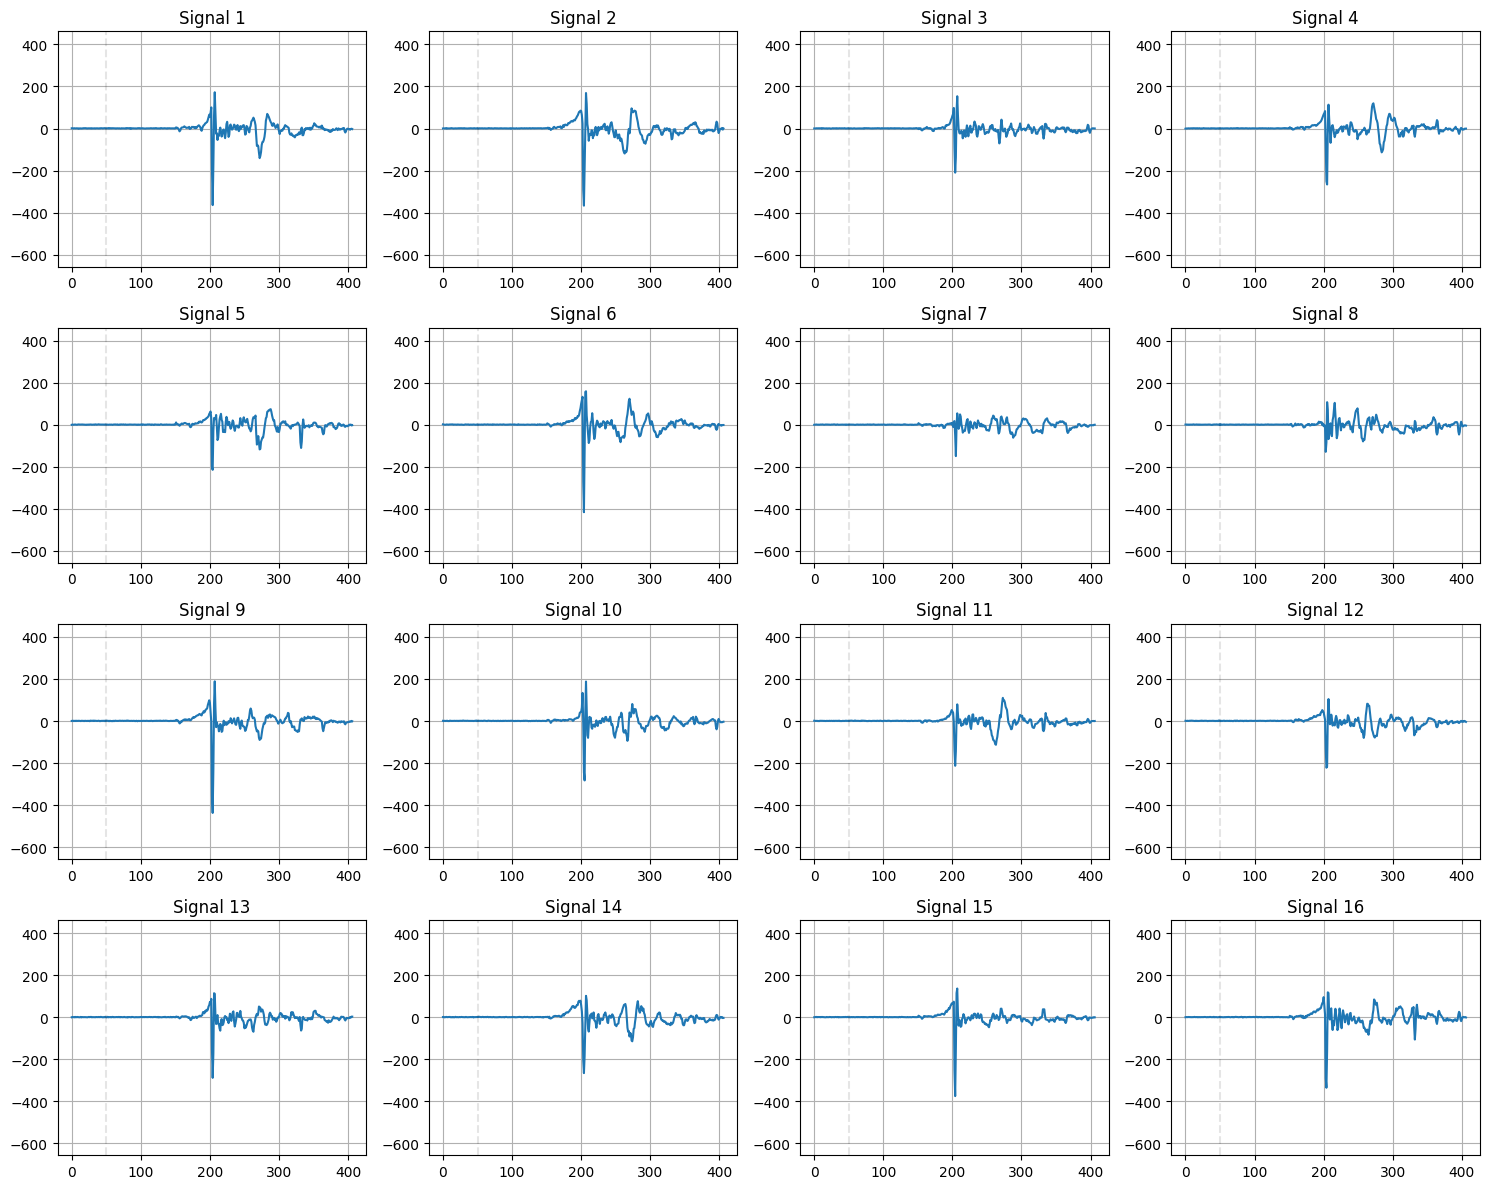

[12/32][0/188]	Loss_D: 0.6698	Loss_G: 1.6810	D(x): 0.8691	D(G(z)): 0.2846 / 0.2478
[12/32][50/188]	Loss_D: 0.6452	Loss_G: 2.1504	D(x): 0.8399	D(G(z)): 0.1939 / 0.1747
[12/32][100/188]	Loss_D: 0.6813	Loss_G: 1.5932	D(x): 0.8577	D(G(z)): 0.2699 / 0.2685
[12/32][150/188]	Loss_D: 0.7302	Loss_G: 1.9273	D(x): 0.8420	D(G(z)): 0.2556 / 0.2176
Epoch 12: SGD Discriminator lr 0.0000160 -> 0.0000157
Epoch 12: SGD Generator lr 0.0000160 -> 0.0000157


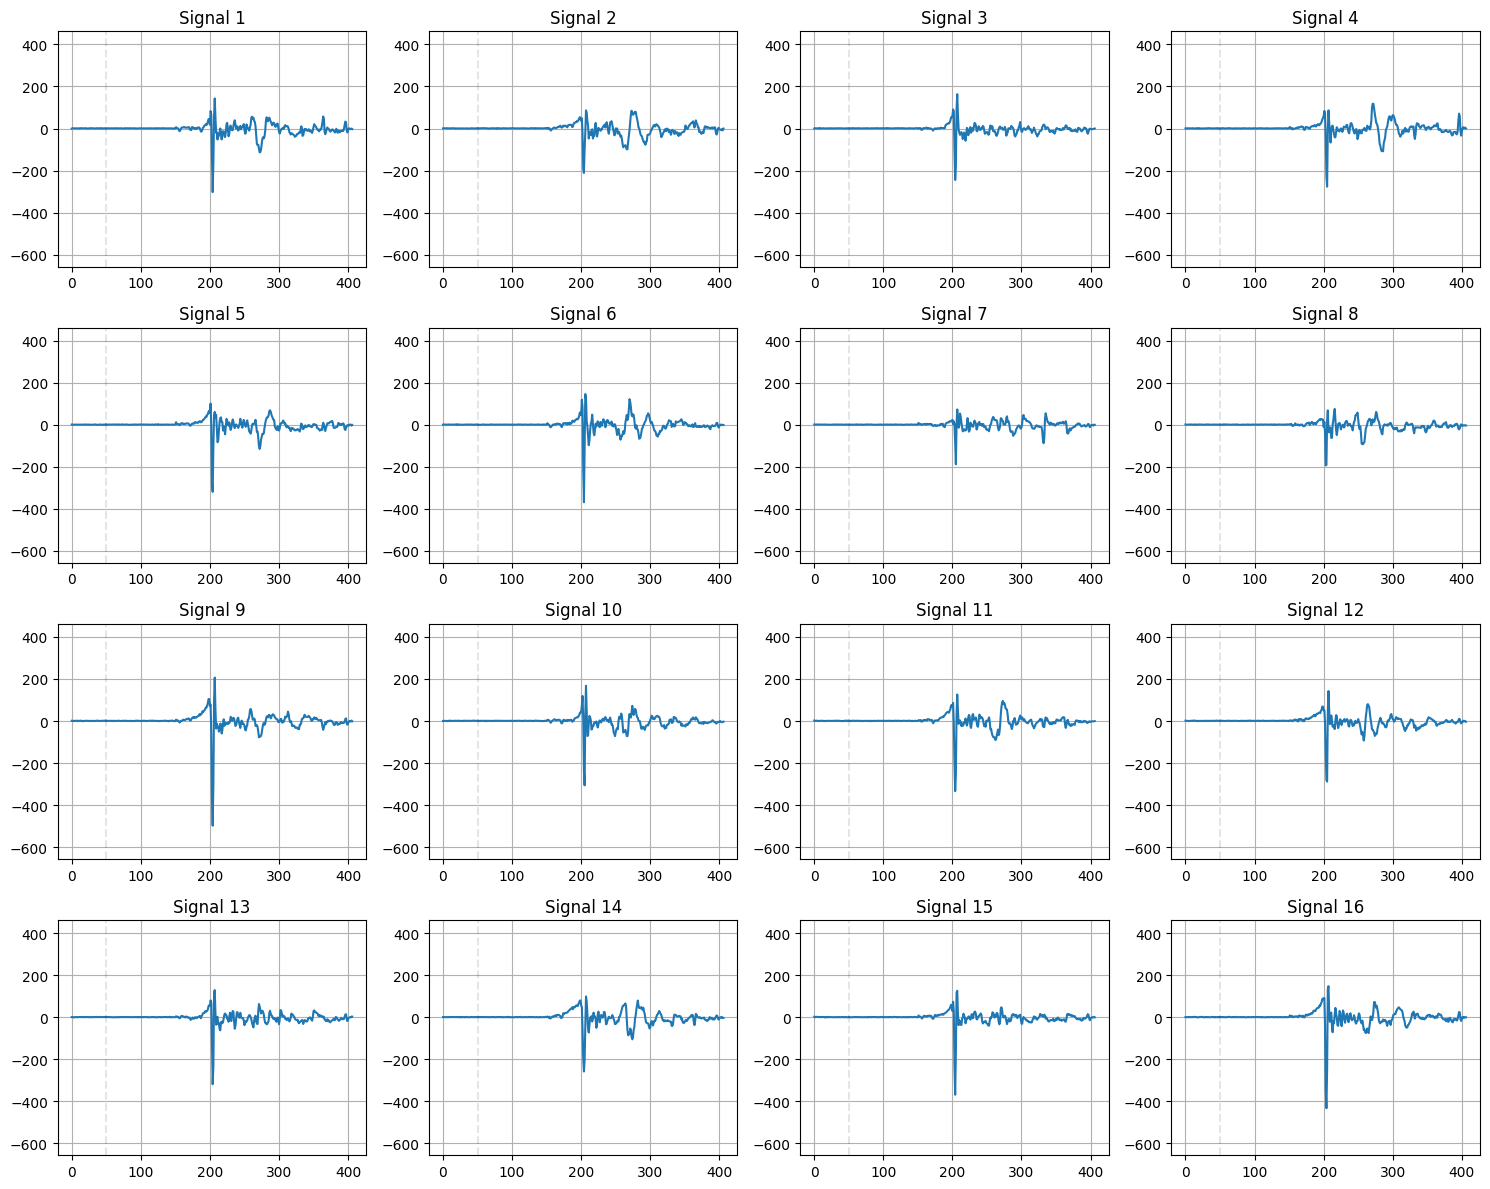

[13/32][0/188]	Loss_D: 0.6796	Loss_G: 1.6068	D(x): 0.8865	D(G(z)): 0.1840 / 0.2768
[13/32][50/188]	Loss_D: 0.8220	Loss_G: 1.4599	D(x): 0.8115	D(G(z)): 0.3465 / 0.2808
[13/32][100/188]	Loss_D: 0.6898	Loss_G: 1.7791	D(x): 0.8479	D(G(z)): 0.2117 / 0.2596
[13/32][150/188]	Loss_D: 0.6672	Loss_G: 1.4603	D(x): 0.8105	D(G(z)): 0.2124 / 0.2819
Epoch 13: SGD Discriminator lr 0.0000157 -> 0.0000153
Epoch 13: SGD Generator lr 0.0000157 -> 0.0000153


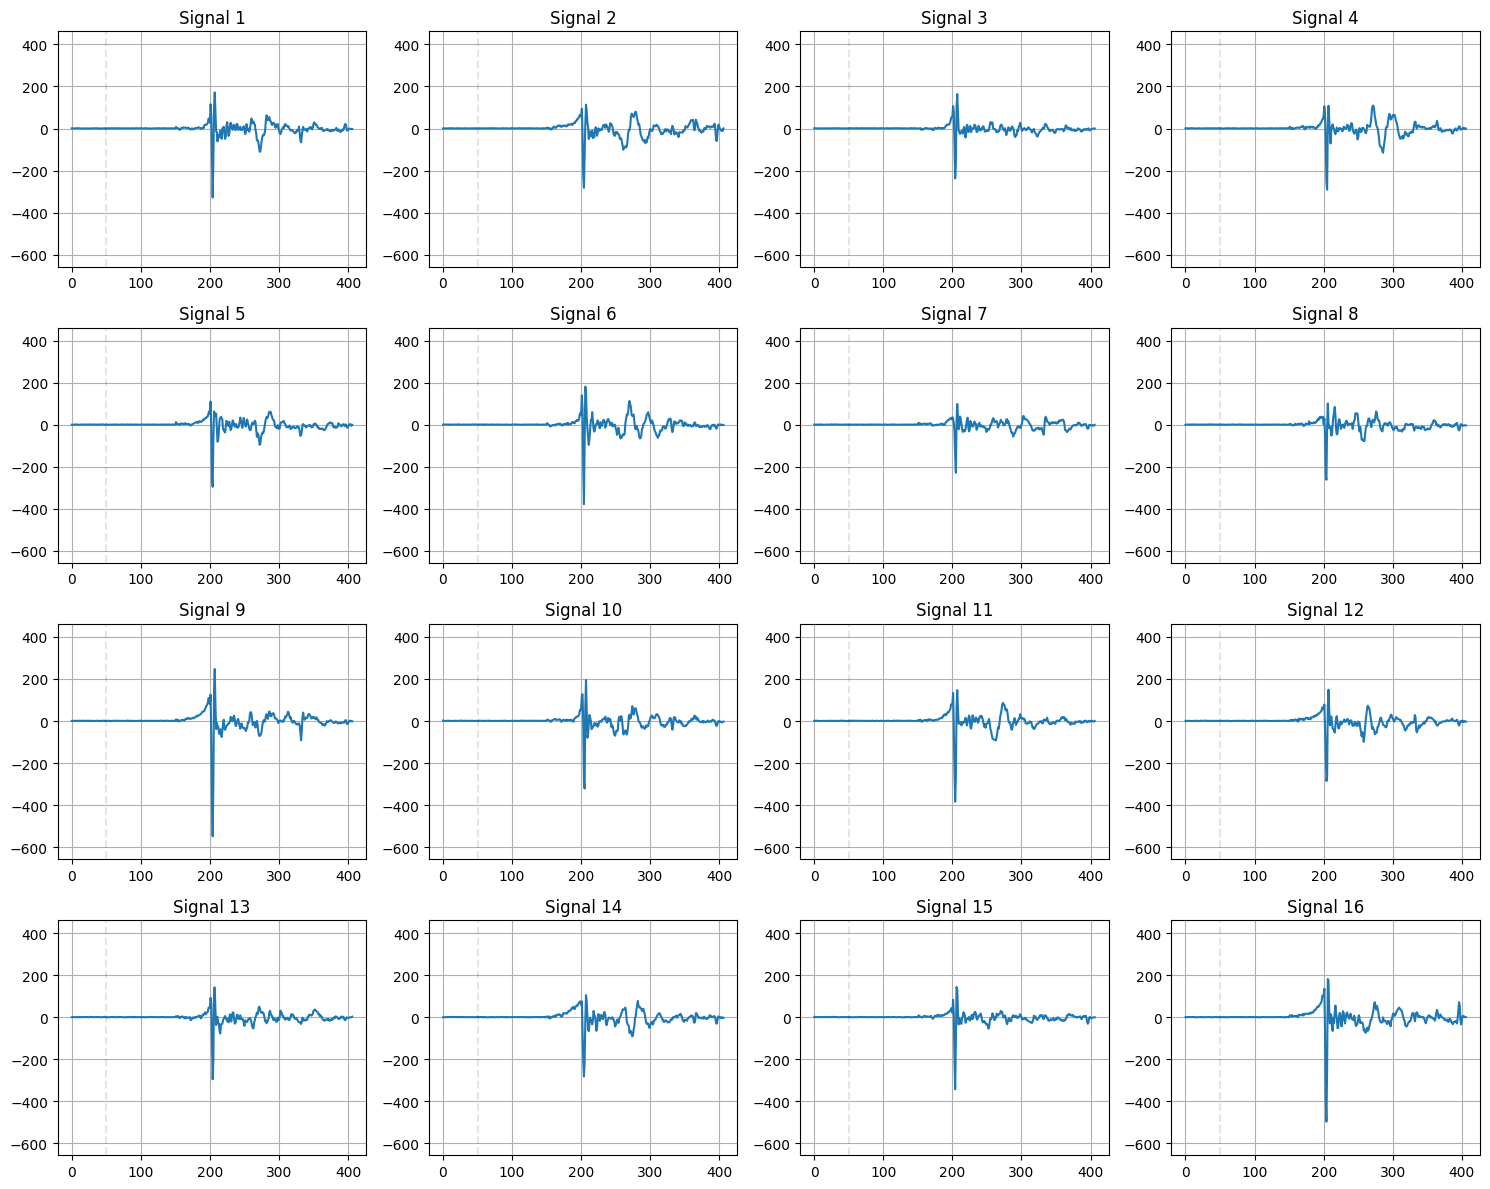

[14/32][0/188]	Loss_D: 0.7000	Loss_G: 1.4223	D(x): 0.8558	D(G(z)): 0.2812 / 0.2923
[14/32][50/188]	Loss_D: 0.6550	Loss_G: 1.6757	D(x): 0.9026	D(G(z)): 0.3055 / 0.2767
[14/32][100/188]	Loss_D: 0.8153	Loss_G: 1.8740	D(x): 0.7770	D(G(z)): 0.2470 / 0.2201
[14/32][150/188]	Loss_D: 0.6030	Loss_G: 1.7399	D(x): 0.8992	D(G(z)): 0.2483 / 0.2395
Epoch 14: SGD Discriminator lr 0.0000153 -> 0.0000150
Epoch 14: SGD Generator lr 0.0000153 -> 0.0000150


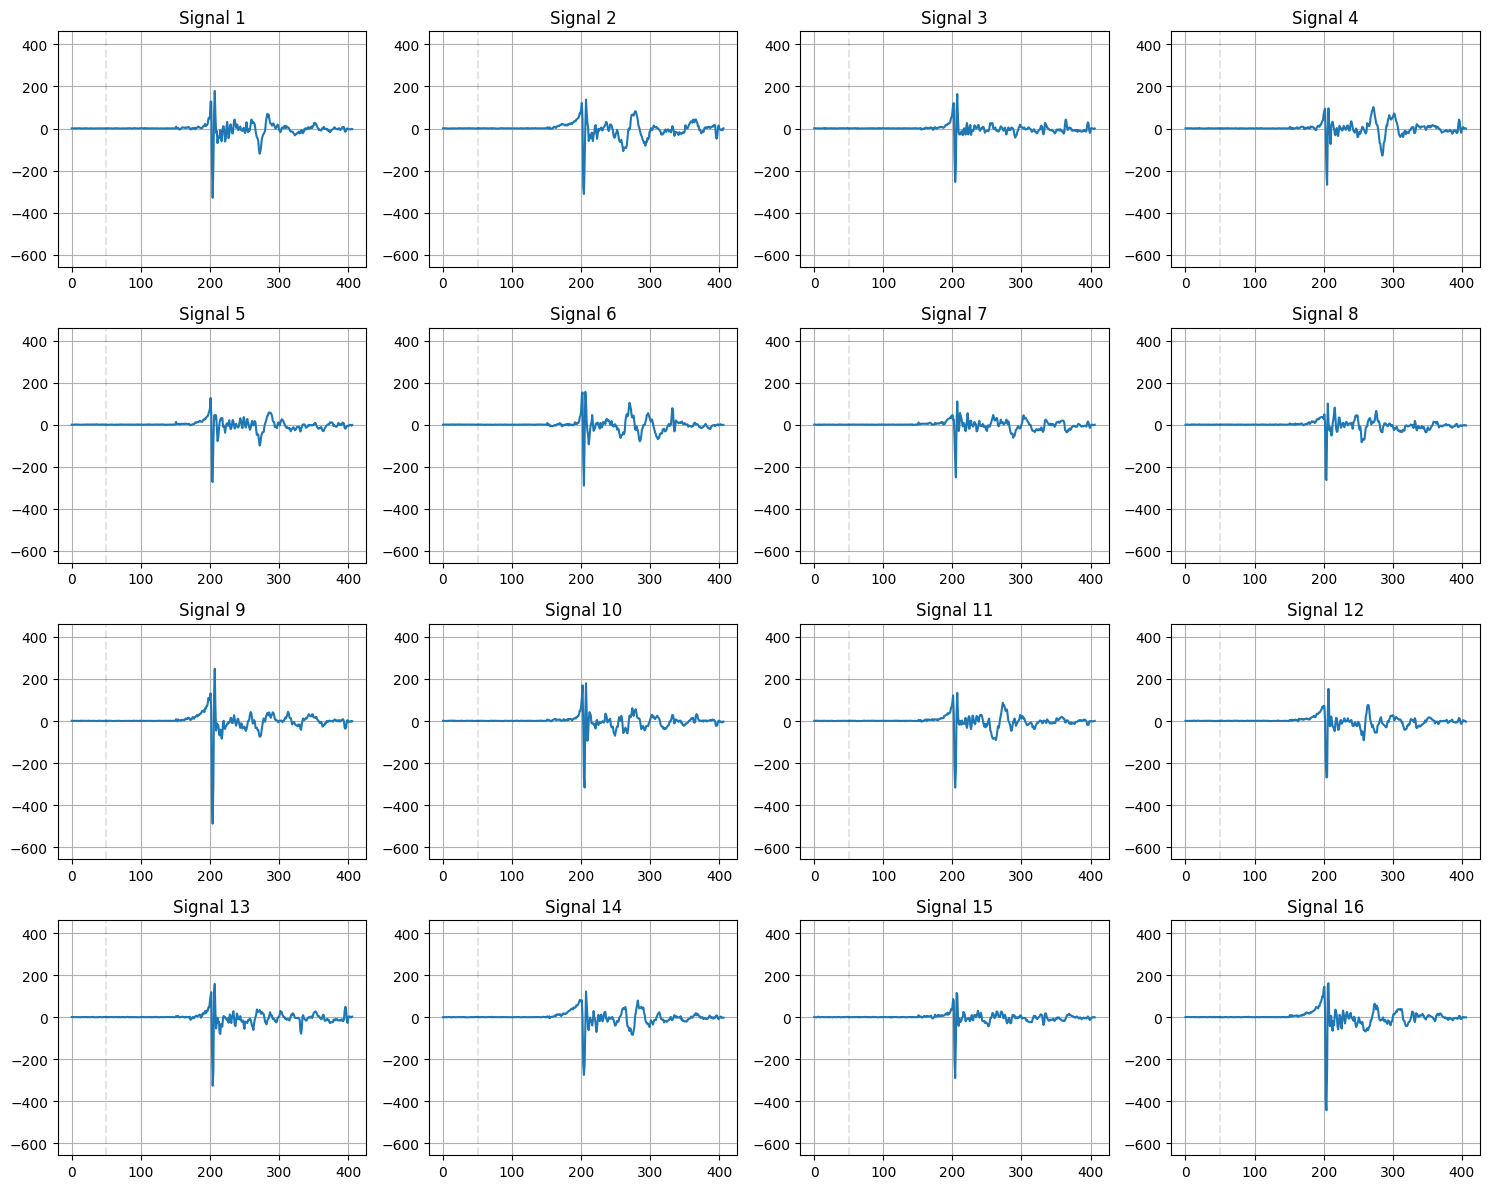

[15/32][0/188]	Loss_D: 0.7822	Loss_G: 1.8661	D(x): 0.8302	D(G(z)): 0.2093 / 0.2593
[15/32][50/188]	Loss_D: 0.7786	Loss_G: 2.3252	D(x): 0.8270	D(G(z)): 0.2772 / 0.1712
[15/32][100/188]	Loss_D: 0.7553	Loss_G: 1.6796	D(x): 0.8193	D(G(z)): 0.2691 / 0.2758
[15/32][150/188]	Loss_D: 0.6784	Loss_G: 1.9228	D(x): 0.8696	D(G(z)): 0.2531 / 0.2461
Epoch 15: SGD Discriminator lr 0.0000150 -> 0.0000147
Epoch 15: SGD Generator lr 0.0000150 -> 0.0000147


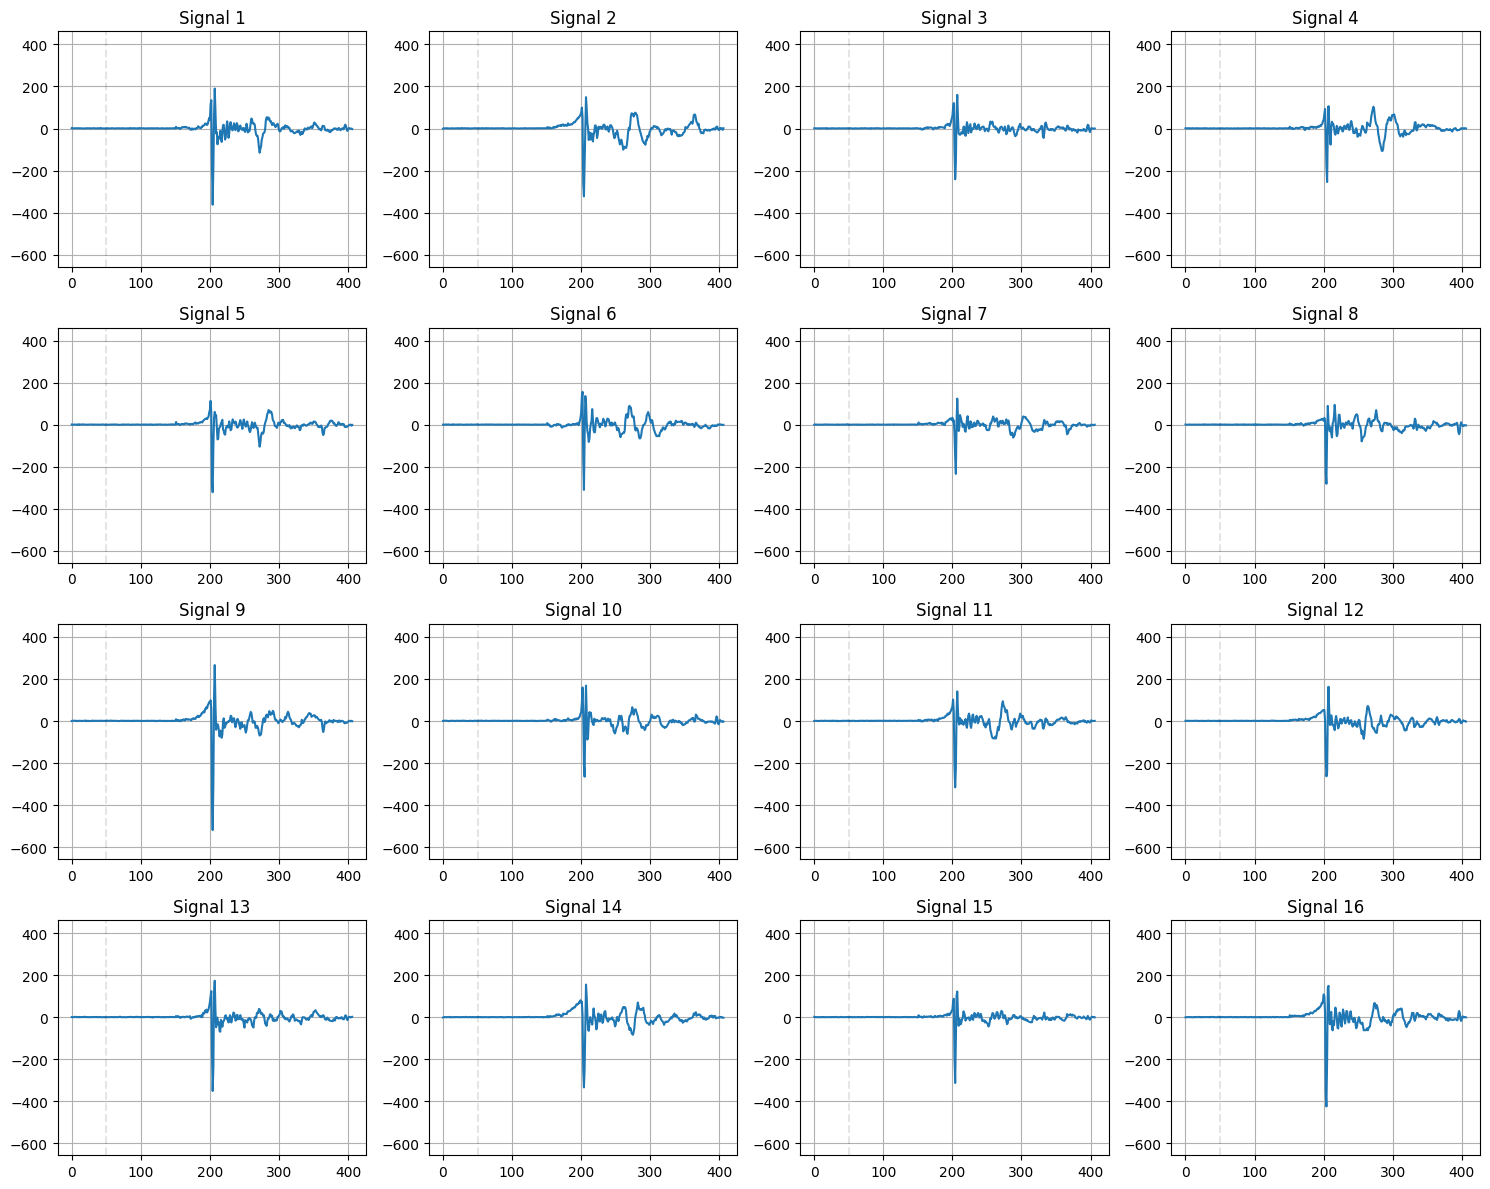

[16/32][0/188]	Loss_D: 0.7886	Loss_G: 1.7046	D(x): 0.8155	D(G(z)): 0.3312 / 0.2533
[16/32][50/188]	Loss_D: 0.7733	Loss_G: 1.6419	D(x): 0.8034	D(G(z)): 0.2868 / 0.2664
[16/32][100/188]	Loss_D: 0.7641	Loss_G: 1.7635	D(x): 0.8078	D(G(z)): 0.2527 / 0.2468
[16/32][150/188]	Loss_D: 0.7169	Loss_G: 1.8758	D(x): 0.8011	D(G(z)): 0.2095 / 0.2278
Epoch 16: SGD Discriminator lr 0.0000147 -> 0.0000143
Epoch 16: SGD Generator lr 0.0000147 -> 0.0000143


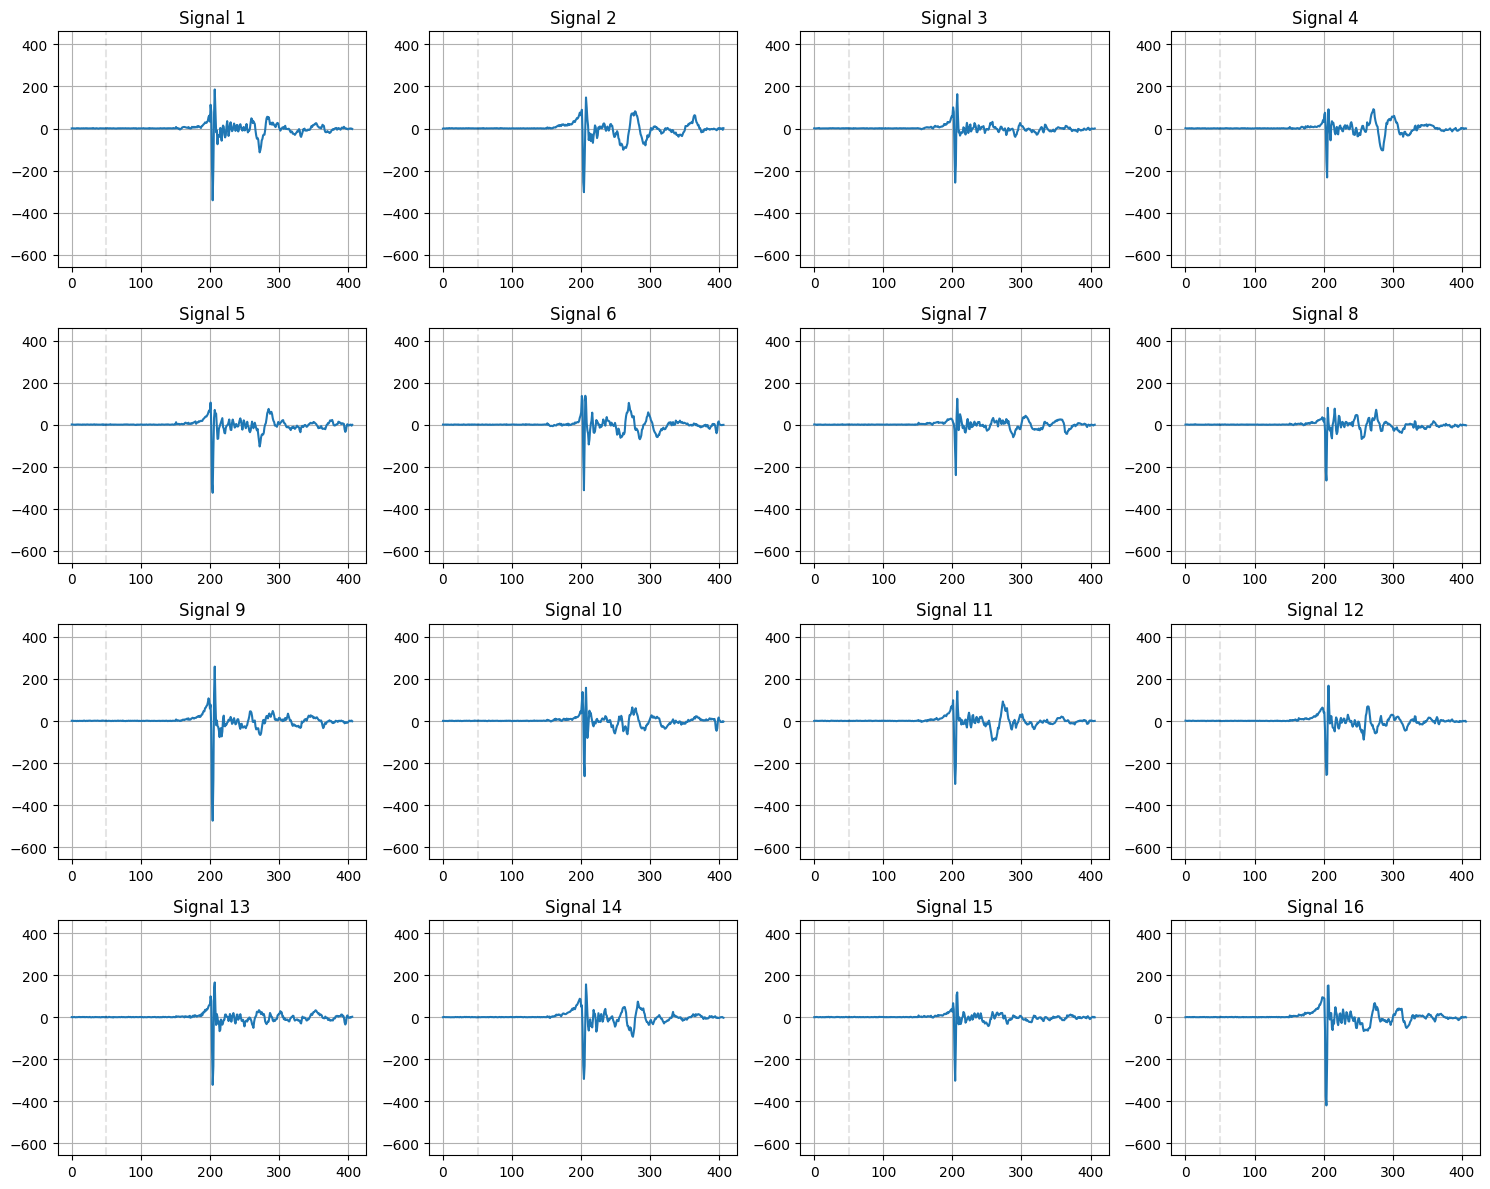

[17/32][0/188]	Loss_D: 0.6795	Loss_G: 1.4630	D(x): 0.8562	D(G(z)): 0.2758 / 0.2869
[17/32][50/188]	Loss_D: 0.7221	Loss_G: 2.0348	D(x): 0.8525	D(G(z)): 0.2224 / 0.2026


KeyboardInterrupt: 

In [87]:
# Training Loop

# Lists to keep track of progress
signal_list = []
G_losses = []
D_losses = []
D_gradients = []
G_gradients = []
iters = 0

# label flip probability
flip_p = 0.0

if (gans_type == 'dcgans' or gans_type == 'gans'):
    print("Starting Training Loop...")
    # For each epoch
    for epoch in range(num_epochs):
        # For each batch in the dataloader
        for i, data in enumerate(dataloader, 0):

            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # Format batch
            real_gpu = data[0].to(device)
            real_parameters_gpu = data[1].to(device)
            b_size = real_gpu.size(0)

            # determine which index of batch to flip on
            flip_mask = torch.rand(b_size) < flip_p

            # label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            # soft labelling
            label = torch.FloatTensor(b_size).uniform_(1.0, 1.0)
            # flip selected labels
            label = torch.where(flip_mask, 1.0 - label, label).to(device)

            # Forward pass real batch through D
            output = netD(real_gpu).view(-1) # add parameters here!!!
            # output = netD(real_gpu, real_parameters_gpu).view(-1)
            # print(output)
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, nz, 1, device=device) # do we increase nz by 3 for parameters?
            # Generate fake signal batch with G
            fake = netG(noise)
            # label.fill_(fake_label)
            label = torch.FloatTensor(b_size).uniform_(0.0, 0.25)
            label = torch.where(flip_mask, 1.0 - label, label).to(device)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()
            # Calculate gradients of discriminator parameters
            D_gradients.append([param.grad.norm().item() for param in netD.parameters()])

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            # label.fill_(real_label)  # fake labels are real for generator cost
            label = torch.FloatTensor(b_size).uniform_(1.0, 1.0)
            label = torch.where(flip_mask, 1.0 - label, label).to(device)
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()
            # Calculate gradients of generator parameters
            G_gradients.append([param.grad.norm().item() for param in netG.parameters()])

            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch, num_epochs, i, len(dataloader),
                        errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            iters += 1 
        
        # learning-rate decay
        before_lr = optimizerD.param_groups[0]["lr"]
        schedulerD.step()
        after_lr = optimizerD.param_groups[0]["lr"]
        print("Epoch %d: SGD Discriminator lr %.7f -> %.7f" % (epoch, before_lr, after_lr))

        before_lr = optimizerG.param_groups[0]["lr"]
        schedulerG.step()
        after_lr = optimizerG.param_groups[0]["lr"]
        print("Epoch %d: SGD Generator lr %.7f -> %.7f" % (epoch, before_lr, after_lr))
        
        with torch.no_grad():
            fake_signals = netG(fixed_noise).detach().cpu()
            fig, axes = plt.subplots(4, 4, figsize=(15, 12))

            axes = axes.flatten()

            # plot each signal on a separate subplot
            for i, ax in enumerate(axes):
                x = np.arange(407)
                y = fake_signals[i, :, :].flatten()
                y = y * dataset.scaling_factor
                y = y * dataset.std + dataset.mean
                background_noise_generated = np.random.normal(dataset.background_noise_mean, dataset.background_noise_std, int(407-256))
                y = np.concatenate((background_noise_generated, y))
                
                ax.plot(x, y)

                ax.axvline(x=50, color='black', linestyle='--', alpha=0.1)
                ax.set_title(f'Signal {i+1}')
                ax.grid(True)
                ax.set_ylim(common_ylim_signal)

            for i in range(512, 8*4):
                fig.delaxes(axes[i])

            plt.tight_layout()
            # plt.savefig('../data/gw-dcgans-images/gw-dcgans_epoch_non_augment_%d.png' % (epoch + 1))
            plt.show()
        
        # print(time.time())
        signal_list.append(fake_signals)

In [ ]:
if (gans_type == 'cdcgans' or gans_type == 'fccdcgans'):
    print("Starting Training Loop...")
    # For each epoch
    for epoch in range(num_epochs):
        # For each batch in the dataloader
        for i, data in enumerate(dataloader, 0):
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # Format batch
            real_signals_gpu = data[0].to(device)
            real_parameters_gpu = data[1].to(device)
            b_size = real_signals_gpu.size(0)

            # determine which index of batch to flip on
            flip_mask = torch.rand(b_size) < flip_p

            # label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            # soft labelling
            label = torch.FloatTensor(b_size).uniform_(1.0, 1.0)
            # flip selected labels
            label = torch.where(flip_mask, 1.0 - label, label).to(device)

            # Forward pass real batch through D
            ### conditional implementation ###
            output = netD(real_signals_gpu, real_parameters_gpu).view(-1)
            ######
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, nz, 1, device=device)

            ### conditional implementation
            # generate random parameters
            # random_indices = torch.randint(0, num_classes, (b_size,)).long()
            # random_one_hot_encoding = torch.nn.functional.one_hot(random_indices, num_classes=num_classes).float()
            # random_one_hot_encoding = random_one_hot_encoding.unsqueeze(-1)
            # Generate fake signal batch with G
            fake = netG(noise, real_parameters_gpu)
            ######

            # label.fill_(fake_label)
            label = torch.FloatTensor(b_size).uniform_(0.0, 0.25)
            label = torch.where(flip_mask, 1.0 - label, label).to(device)
            # Classify all fake batch with D
            ### conditional implementation ###
            output = netD(fake.detach(), real_parameters_gpu).view(-1)
            ######
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()
            # Calculate gradients of discriminator parameters
            # D_gradients.append([param.grad.norm().item() for param in netD.parameters()])

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            # label.fill_(real_label)  # fake labels are real for generator cost
            label = torch.FloatTensor(b_size).uniform_(1.0, 1.0)
            label = torch.where(flip_mask, 1.0 - label, label).to(device)
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake, real_parameters_gpu).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()
            # Calculate gradients of generator parameters
            # G_gradients.append([param.grad.norm().item() for param in netG.parameters()])

            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch, num_epochs, i, len(dataloader),
                        errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            iters += 1 
        
        # learning-rate decay
        before_lr = optimizerD.param_groups[0]["lr"]
        schedulerD.step()
        after_lr = optimizerD.param_groups[0]["lr"]
        print("Epoch %d: SGD Discriminator lr %.7f -> %.7f" % (epoch, before_lr, after_lr))

        before_lr = optimizerG.param_groups[0]["lr"]
        schedulerG.step()
        after_lr = optimizerG.param_groups[0]["lr"]
        print("Epoch %d: SGD Generator lr %.7f -> %.7f" % (epoch, before_lr, after_lr))
        
        with torch.no_grad():
            fake_signals = netG(fixed_noise, fixed_random_one_hot_encoding).detach().cpu()
            fig, axes = plt.subplots(4, 4, figsize=(15, 12))

            axes = axes.flatten()

            # plot each signal on a separate subplot
            for i, ax in enumerate(axes):
                x = np.arange(fake_signals.size(dim=2))
                y = fake_signals[i, :, :].flatten()
                y = y * dataset.scaling_factor
                y = y * dataset.std + dataset.mean
                ax.plot(x, y)

                ax.axvline(x=50, color='black', linestyle='--', alpha=0.1)
                ax.set_title(f'Signal {i+1}')
                ax.grid(True)
                ax.set_ylim(common_ylim_signal)

            for i in range(512, 8*4):
                fig.delaxes(axes[i])

            plt.tight_layout()
            plt.savefig('../data/gw-dcgans-images/gw-dcgans_epoch_cgans_%d.png' % (epoch + 1))
            plt.show()
        
        # print(time.time())
        signal_list.append(fake_signals)

### Gradients

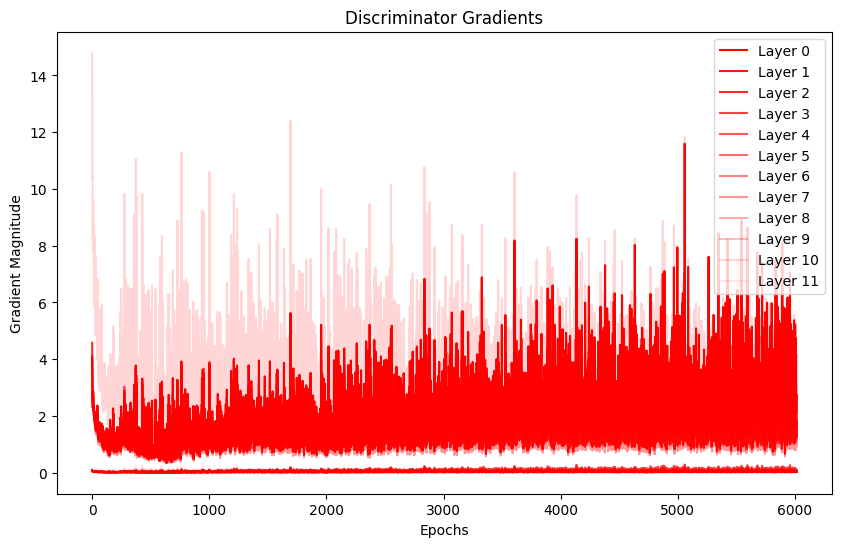

In [ ]:
# Get the total number of layers in the discriminator
D_gradients = np.array(D_gradients)
num_layers = D_gradients.shape[1]

# Plot the gradients over training epochs
plt.figure(figsize=(10, 6))
for i in range(num_layers):
    # Calculate alpha value based on layer index
    alpha = 1 - (i / num_layers)  # Higher layers are more transparent
    plt.plot(D_gradients[:, i], label=f'Layer {i}', alpha=alpha, color=(1, 0, 0, alpha))

plt.xlabel('Epochs')
plt.ylabel('Gradient Magnitude')
plt.title('Discriminator Gradients')
plt.legend()
plt.show()

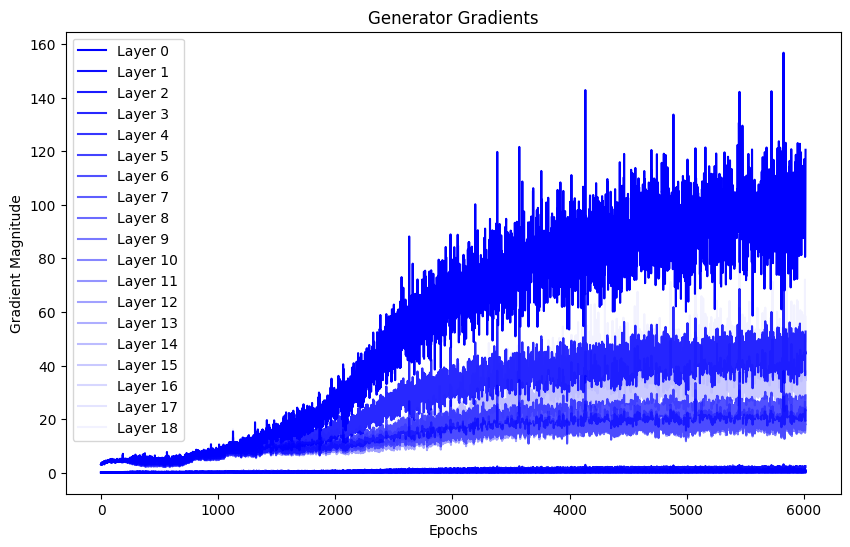

In [ ]:
# Get the total number of layers in the discriminator
G_gradients = np.array(G_gradients)
num_layers = G_gradients.shape[1]

# Plot the gradients over training epochs
plt.figure(figsize=(10, 6))
for i in range(num_layers):
    # Calculate alpha value based on layer index
    alpha = 1 - (i / num_layers)  # Higher layers are more transparent
    plt.plot(G_gradients[:, i], label=f'Layer {i}', alpha=alpha, color=(0, 0, 1, alpha))

plt.xlabel('Epochs')
plt.ylabel('Gradient Magnitude')
plt.title('Generator Gradients')
plt.legend()
plt.show()

### Loss

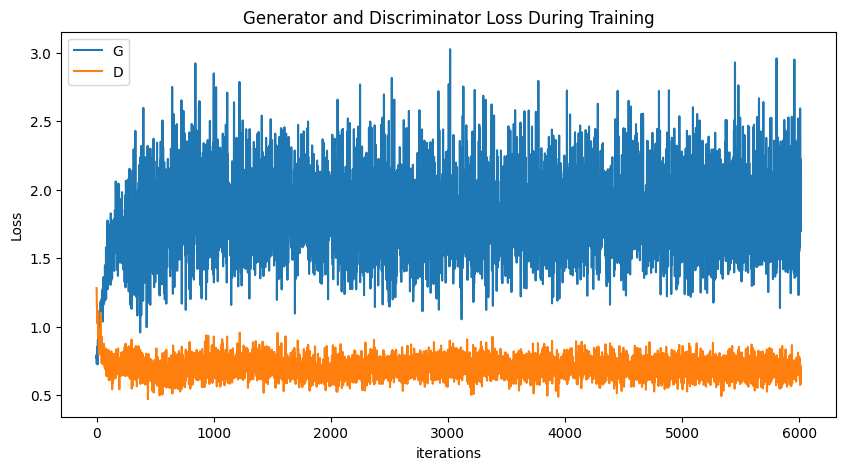

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig("../plots/gw_dcgans_train_losses.png")
plt.show()

### Generated Signals

torch.Size([32, 1, 256])


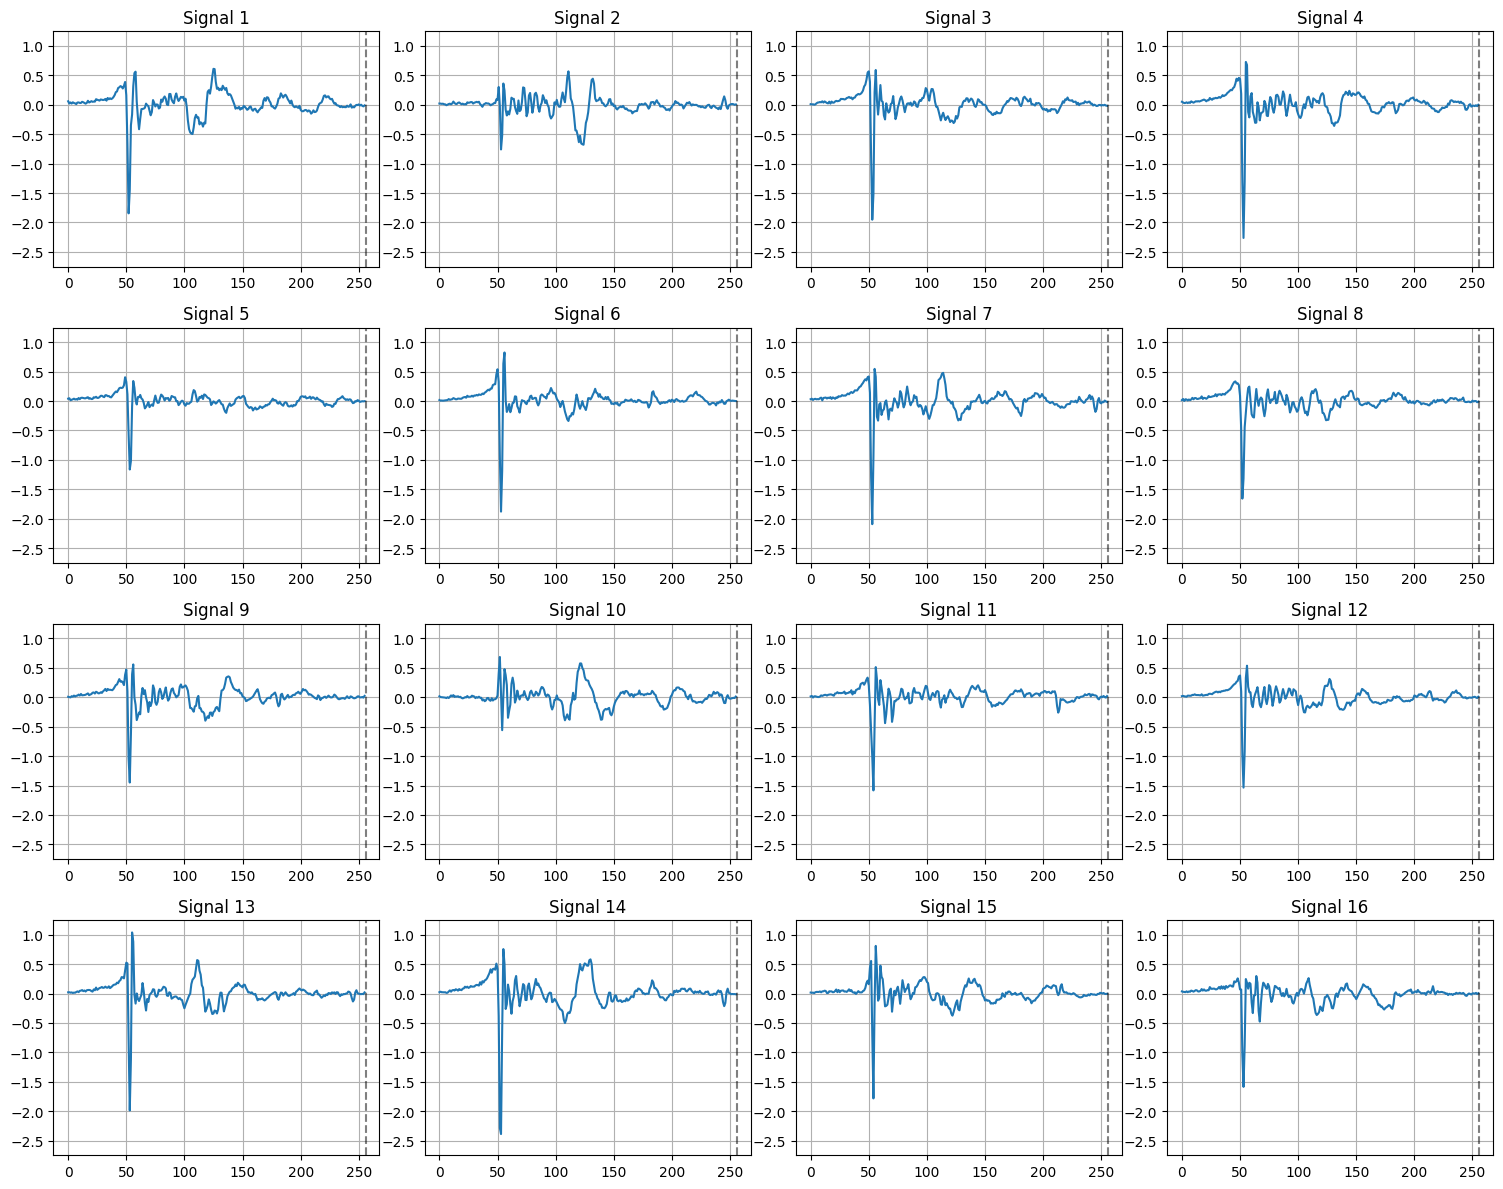

In [ ]:
batch = signal_list[19]

# # plotting a single batch
# def plot_waveforms(batch):
#     fig, axs = plt.subplots(8, int(batch_size/8), figsize=(12, 12))
#     axs = axs.ravel()
    
#     for i in range(len(batch)):
#         signal = batch[i].squeeze()
#         axs[i].plot(signal)
#         axs[i].set_title(f'Signal {i+1}')
#         axs[i].axis('off')
    
#     plt.tight_layout()
#     plt.show()

# plot_waveforms(batch)

# Expecting: (32, 1, 512)
print(batch.shape)

# common_ylim = (batch[:,:,:].min(), batch[:,:,:].max())

fig, axes = plt.subplots(4, 4, figsize=(15, 12))

axes = axes.flatten()

# plot each signal on a separate subplot
for i, ax in enumerate(axes):
    x = np.arange(batch.size(dim=2))
    y = batch[i, :, :].flatten()
    ax.plot(x, y)

    ax.axvline(x=256, color='black', linestyle='--', alpha=0.5)
    ax.set_title(f'Signal {i+1}')
    ax.grid(True)
    ax.set_ylim(common_ylim)

for i in range(512, 8*4):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig('../data/gw-dcgans-plots/generated_data.png')
plt.show()

In [ ]:
# for signal processing
%store signal_list

Stored 'signal_list' (list)


### Evaluation Metrics for GANS